# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb
from sklearn.model_selection import train_test_split 

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module, ZINB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed, get_activation
from base.model.decoder import Decoder
from base.data.combined import GeneExpressionDatasetCombined
from base.engine.train import train_midgd

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cuda


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_transposed.tsv", sep='\t', index_col=[0])
# tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_transposed.tsv", sep='\t', index_col=[0])
tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [6]:
def data_filtering(df, filter_zero=True, filter_tumor=True, filter_type=True):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal', 'Primary Blood Derived Cancer - Peripheral Blood'])]
    if filter_type:
        count = df['cancer_type'].value_counts().reset_index()
        keep = count[count['count'] > 100]['cancer_type']
        df = df[df['cancer_type'].isin(keep)]
    return df

# Filter data
tcga_mrna = data_filtering(tcga_mrna_raw)
tcga_mirna = data_filtering(tcga_mirna_raw)

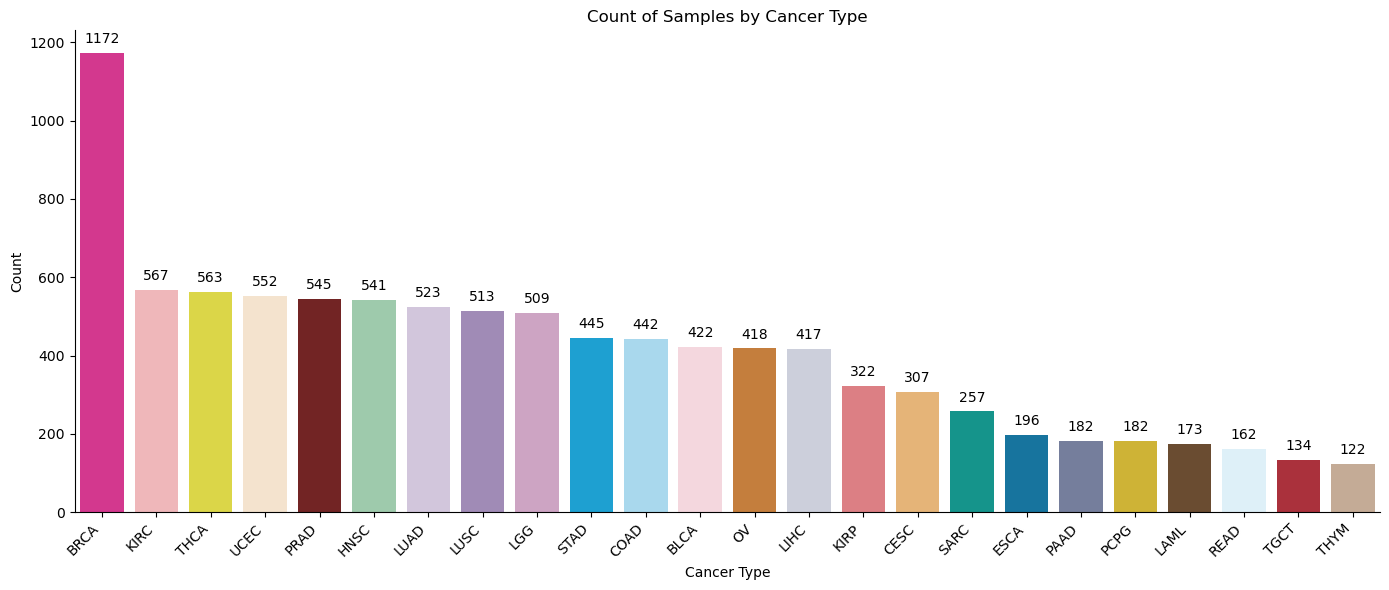

In [7]:
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

primary_site_counts = tcga_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
sns.despine()
plt.show()

In [8]:
# shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [9]:
# make data split for train, validation, and test sets
train_ratio= 0.8
batch_size = 128
scaling_type = 'mean'

# Split data
train_mrna, val_mrna = train_test_split(tcga_mrna, train_size=train_ratio, stratify=tcga_mrna['cancer_type'], random_state=seed) 
val_mrna, test_mrna = train_test_split(val_mrna, test_size=0.50, stratify=val_mrna['cancer_type'], random_state=seed)

# Get the indices of the samples in each split
train_idx = train_mrna.index
val_idx = val_mrna.index
test_idx = test_mrna.index

# Use the same indices to split tcga_mirna
train_mirna = tcga_mirna.loc[train_idx]
val_mirna = tcga_mirna.loc[val_idx]
test_mirna = tcga_mirna.loc[test_idx]

# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna, scaling_type=scaling_type)
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna, scaling_type=scaling_type)
test_dataset = GeneExpressionDatasetCombined(test_mrna, test_mirna, scaling_type=scaling_type)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)

In [10]:
# make data split for train and validation sets
mrna_out_dim = tcga_mrna.shape[1]-4
mirna_out_dim = tcga_mirna.shape[1]-4

In [11]:
print(train_dataset.mrna_data.shape)
print(validation_dataset.mrna_data.shape)
# print(test_dataset.mrna_data.shape)

print(train_dataset.mirna_data.shape)
print(validation_dataset.mirna_data.shape)
# print(test_dataset.mirna_data.shape)

print(mrna_out_dim)
print(mirna_out_dim)

torch.Size([7732, 19741])
torch.Size([967, 19741])
torch.Size([7732, 2024])
torch.Size([967, 2024])
19741
2024


In [12]:
n_tissues = len(np.unique(train_dataset.label))
n_tissues = 24
n_tissues

24

# Model Setup

In [13]:
# hyperparameters
latent_dim = 20
hidden_dims = [64, 128]
fc_mrna = 256
fc_mirna = 128
activation = "relu"
reduction_type = "sum" # output loss reduction
r_init_mrna = 2
r_init_mirna = 2
pi_init = 0.5

In [14]:
# Decoder setup
# set up an output module for the miRNA expression data
mirna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], 128),
    get_activation(activation),
    nn.Linear(128, fc_mirna),
    get_activation(activation),
    nn.Linear(fc_mirna, mirna_out_dim))
output_mirna_layer = ZINB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init_mirna, pi_init=pi_init, scaling_type=scaling_type)
output_mirna_layer.n_features = mirna_out_dim

# set up an output module for the miRNA expression data
#mirna_out_fc = nn.Sequential(
#    nn.Linear(hidden_dims[-1], fc_mirna),
#    get_activation(activation),
#    nn.Linear(fc_mirna, mirna_out_dim))
#output_mirna_layer = ZINB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init_mirna, pi_init=pi_init, scaling_type=scaling_type)
#output_mirna_layer.n_features = mirna_out_dim

# set up an output module for the mRNA expression data
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], 128),
    get_activation(activation),
    nn.Linear(128, fc_mrna),
    get_activation(activation),
    nn.Linear(fc_mrna, mrna_out_dim))
output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, r_init=r_init_mrna, scaling_type=scaling_type)
output_mrna_layer.n_features = mrna_out_dim

# set up the decoder
decoder = Decoder(latent_dim, 
                  hidden_dims, 
                  output_module_mirna=output_mirna_layer, 
                  output_module_mrna=output_mrna_layer, 
                  activation=activation).to(device)

# setup gmm init
gmm_mean_scale = 5.0 # usually between 2 and 10
sd_mean_init = 0.4 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

In [15]:
# init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

# Training

[1371, 1304, 34, 359]


  0%|                                                                                                                                     | 0/1500 [00:00<?, ?it/s]

0 train_loss: 21.700077597923155 train_recon_mirna: 7.318779769991095 train_recon_mrna: 10.919467057001727 train_gmm: 3.461830770930333 train_mse: 813414720.0 train_mae: 6388.52490234375 train_r2: -0.011884331703186035 train_spearman: 0.08424264937639236 train_pearson: 0.039218880236148834 train_msle: 45.048519134521484
0 test_loss: 20.777024959369 test_recon_mirna: 7.270139402659298 test_recon_mrna: 10.833164244285106 test_gmm: 2.673721312424595 test_mse: 866330624.0 test_mae: 6780.7666015625 test_r2: -0.013554692268371582 test_spearman: 0.011785752139985561 test_pearson: 0.03552106022834778 test_msle: 45.16874694824219


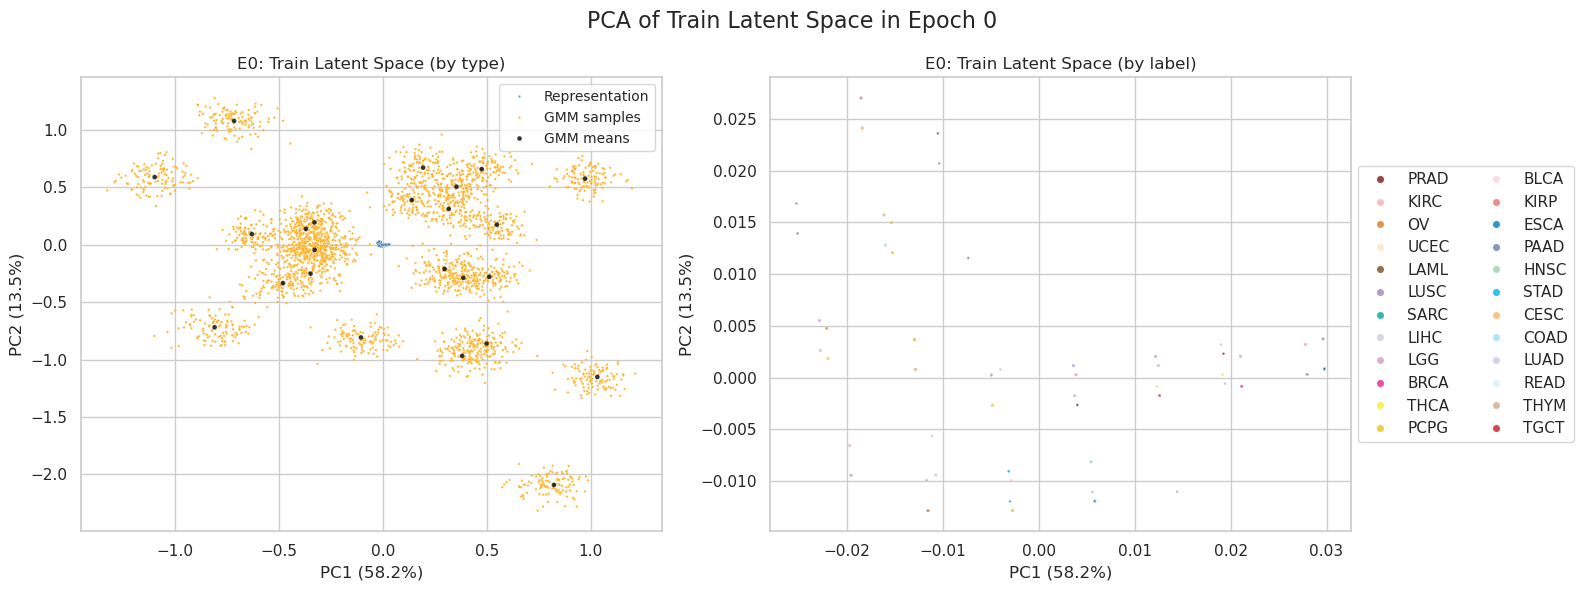

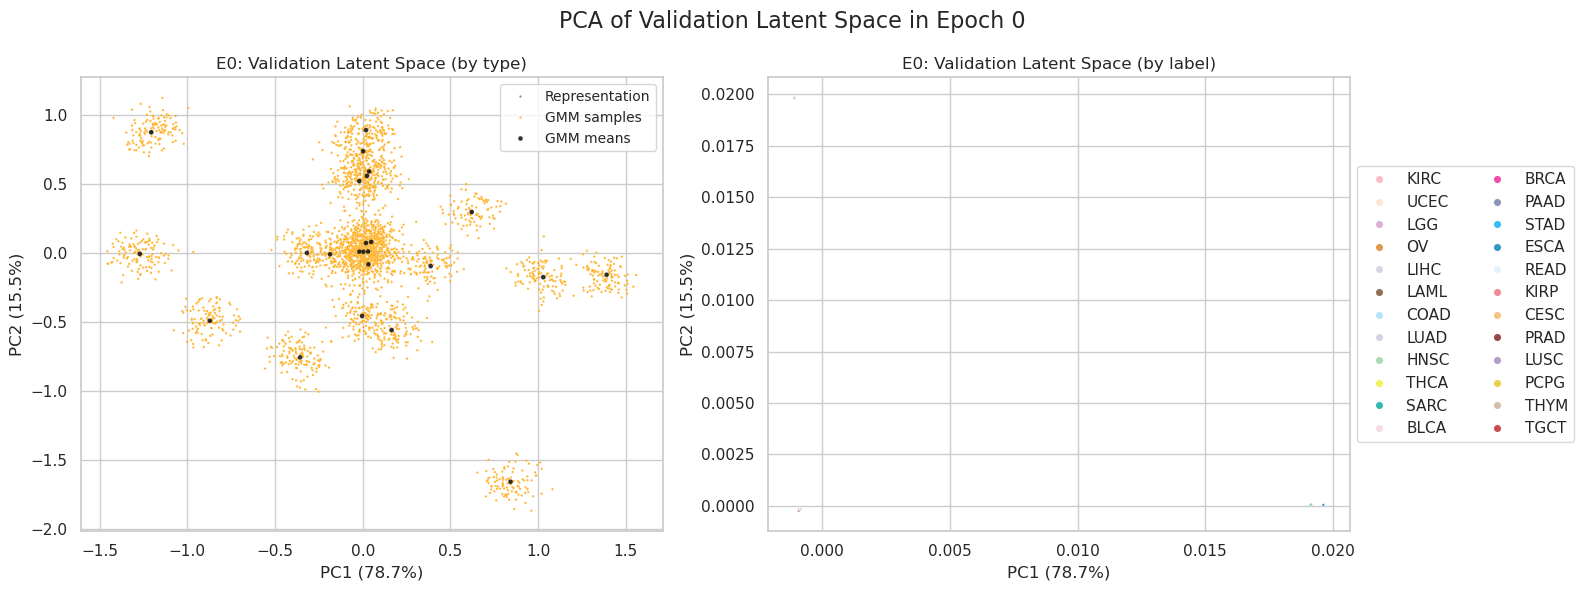

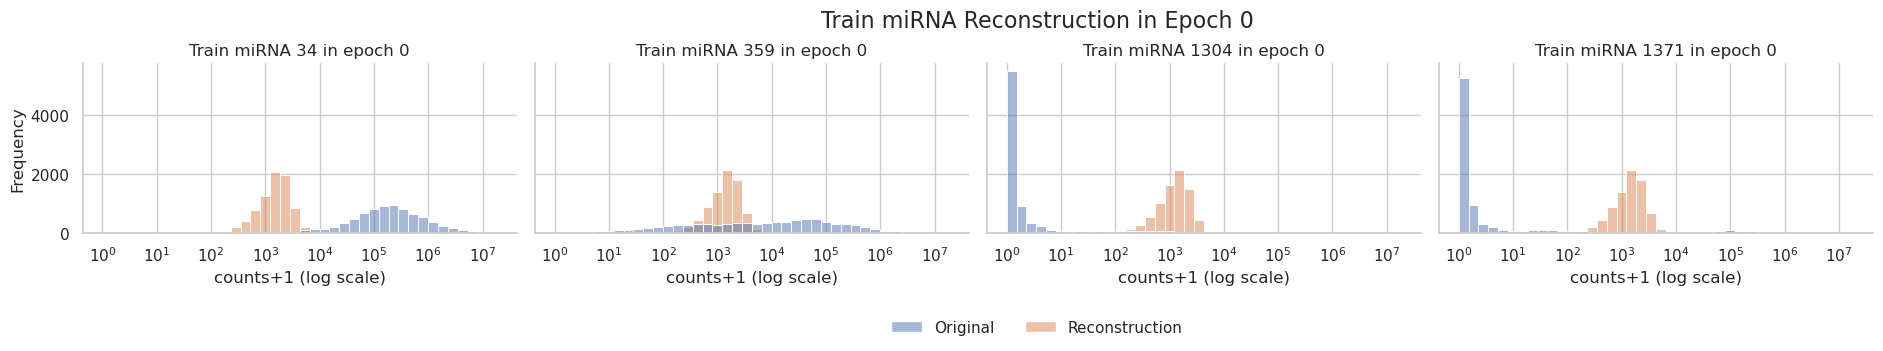

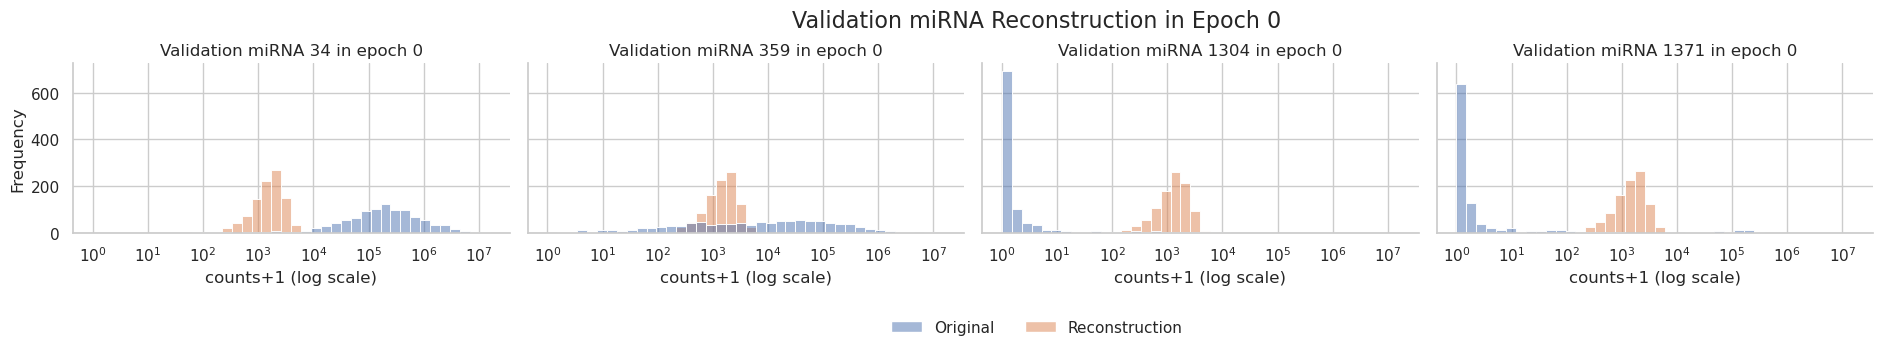

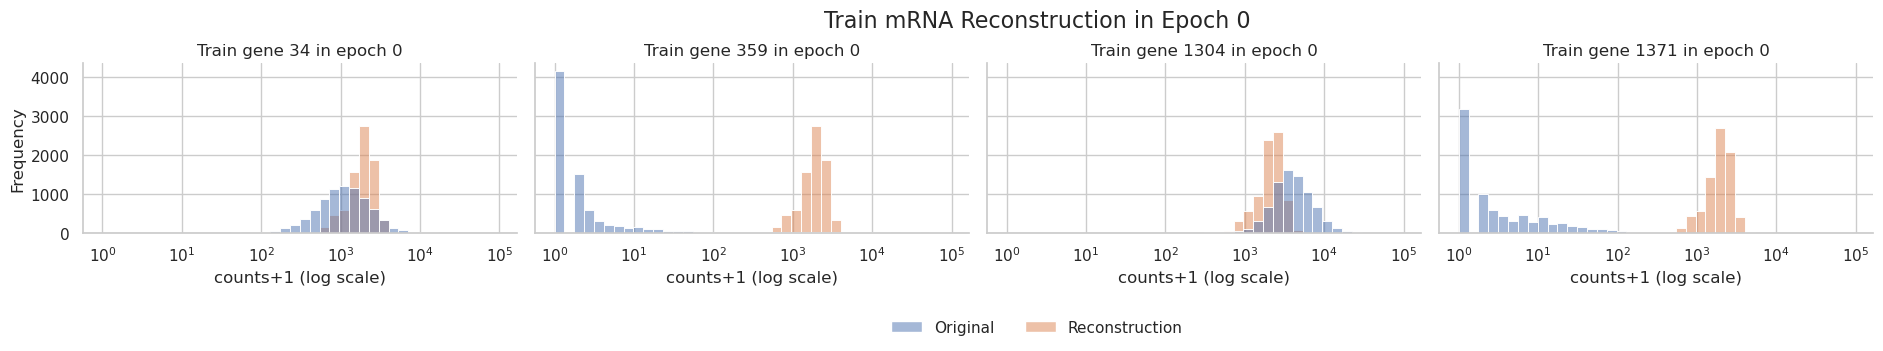

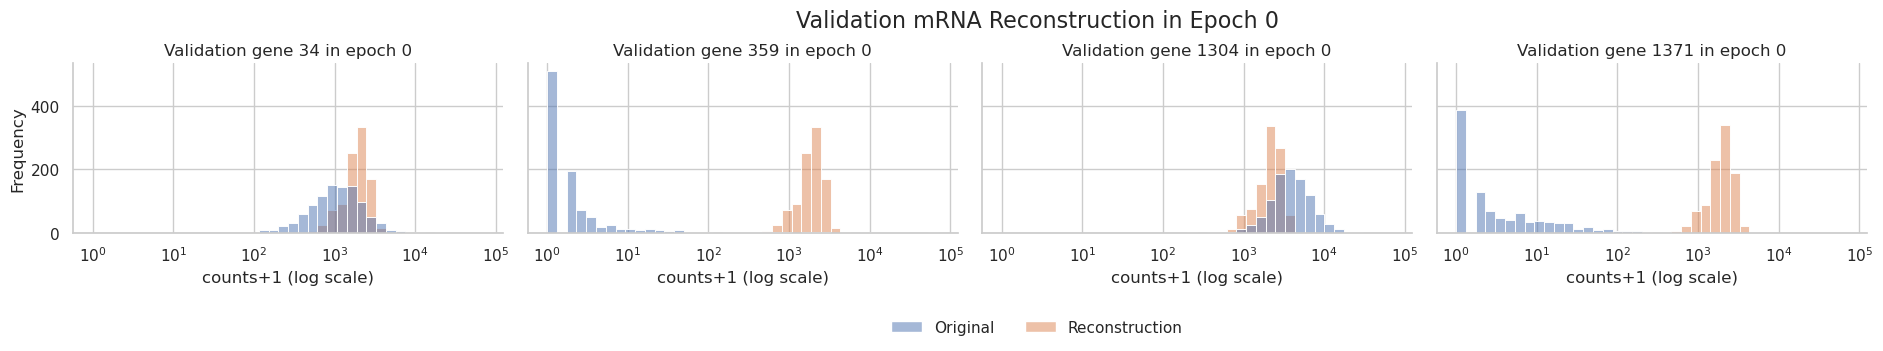

  0%|▍                                                                                                                          | 6/1500 [00:40<1:57:43,  4.73s/it]

5 train_loss: 14.068251363613966 train_recon_mirna: 3.925705756702038 train_recon_mrna: 7.971654400167634 train_gmm: 2.1708912067442934 train_mse: 813992704.0 train_mae: 10947.74609375 train_r2: -0.012603282928466797 train_spearman: 0.07846971601247787 train_pearson: 0.04039944335818291 train_msle: 64.45346069335938
5 test_loss: 13.469405456442813 test_recon_mirna: 3.4697050594520356 test_recon_mrna: 7.8294549367777035 test_gmm: 2.170245460213073 test_mse: 865262336.0 test_mae: 11519.9892578125 test_r2: -0.01230478286743164 test_spearman: 0.005220978055149317 test_pearson: 0.034858155995607376 test_msle: 64.60114288330078


  1%|▉                                                                                                                         | 11/1500 [00:59<1:37:11,  3.92s/it]

10 train_loss: 12.285672794465446 train_recon_mirna: 2.4581867980716785 train_recon_mrna: 7.655730575410962 train_gmm: 2.171755420982807 train_mse: 963549632.0 train_mae: 18506.55859375 train_r2: -0.19865155220031738 train_spearman: 0.06269007921218872 train_pearson: 0.049826834350824356 train_msle: 77.38107299804688
10 test_loss: 12.29991533033094 test_recon_mirna: 2.479816194165362 test_recon_mrna: 7.6482396884535815 test_gmm: 2.171859447711996 test_mse: 1016161024.0 test_mae: 19328.7109375 test_r2: -0.18884718418121338 test_spearman: -0.003419890534132719 test_pearson: 0.04565194621682167 test_msle: 77.48914337158203


  1%|█▎                                                                                                                        | 16/1500 [01:19<1:42:18,  4.14s/it]

15 train_loss: 12.199509778718523 train_recon_mirna: 2.3969806636595337 train_recon_mrna: 7.630370567341642 train_gmm: 2.172158547717346 train_mse: 972846272.0 train_mae: 18841.076171875 train_r2: -0.21021652221679688 train_spearman: 0.06663209944963455 train_pearson: 0.05153992772102356 train_msle: 77.82671356201172
15 test_loss: 12.216976087262992 test_recon_mirna: 2.42008554085718 test_recon_mrna: 7.624591982198425 test_gmm: 2.1722985642073853 test_mse: 1026072576.0 test_mae: 19686.419921875 test_r2: -0.20044314861297607 test_spearman: -0.0010915743187069893 test_pearson: 0.04776325821876526 test_msle: 77.939697265625


  1%|█▋                                                                                                                        | 21/1500 [01:40<1:42:25,  4.16s/it]

20 train_loss: 12.15020414653674 train_recon_mirna: 2.3690339387483412 train_recon_mrna: 7.60889714574039 train_gmm: 2.1722730620480095 train_mse: 960935744.0 train_mae: 18447.08984375 train_r2: -0.19539988040924072 train_spearman: 0.07062342017889023 train_pearson: 0.048358384519815445 train_msle: 77.3504638671875
20 test_loss: 12.160791440214886 test_recon_mirna: 2.3846063180305825 test_recon_mrna: 7.604043982814259 test_gmm: 2.1721411393700447 test_mse: 1013758016.0 test_mae: 19286.732421875 test_r2: -0.1860358715057373 test_spearman: 0.003019080962985754 test_pearson: 0.046012718230485916 test_msle: 77.47364807128906


  2%|██                                                                                                                        | 26/1500 [01:59<1:35:56,  3.91s/it]

25 train_loss: 12.082061538930098 train_recon_mirna: 2.3413207656115493 train_recon_mrna: 7.567937941059955 train_gmm: 2.1728028322585926 train_mse: 967352832.0 train_mae: 18545.17578125 train_r2: -0.2033827304840088 train_spearman: 0.07578014582395554 train_pearson: 0.04413984715938568 train_msle: 77.42285919189453
25 test_loss: 12.092527504310528 test_recon_mirna: 2.362668451053746 test_recon_mrna: 7.557372733884152 test_gmm: 2.1724863193726303 test_mse: 1015062208.0 test_mae: 19280.76171875 test_r2: -0.1875617504119873 test_spearman: 0.0059117903001606464 test_pearson: 0.04271966964006424 test_msle: 77.46411895751953


  2%|██▌                                                                                                                       | 31/1500 [02:20<1:40:32,  4.11s/it]

30 train_loss: 11.955948761716478 train_recon_mirna: 2.3043170265147257 train_recon_mrna: 7.476604936147633 train_gmm: 2.17502679905412 train_mse: 990218176.0 train_mae: 19041.05859375 train_r2: -0.2318270206451416 train_spearman: 0.07310514152050018 train_pearson: 0.03980691730976105 train_msle: 77.89379119873047
30 test_loss: 11.986354569427718 test_recon_mirna: 2.3474783658660705 test_recon_mrna: 7.464532395661354 test_gmm: 2.174343807900293 test_mse: 1033515456.0 test_mae: 19760.21484375 test_r2: -0.20915091037750244 test_spearman: -0.001532121212221682 test_pearson: 0.04028680920600891 test_msle: 77.9632339477539


  2%|██▉                                                                                                                       | 36/1500 [02:39<1:35:13,  3.90s/it]

35 train_loss: 11.862873680695035 train_recon_mirna: 2.2972107101454813 train_recon_mrna: 7.3877756129670225 train_gmm: 2.1778873575825304 train_mse: 975821888.0 train_mae: 18758.42578125 train_r2: -0.21391808986663818 train_spearman: 0.06395050883293152 train_pearson: 0.04767302796244621 train_msle: 77.57453918457031
35 test_loss: 11.892471177475732 test_recon_mirna: 2.3393307424402514 test_recon_mrna: 7.374716120817324 test_gmm: 2.1784243142181574 test_mse: 1031925312.0 test_mae: 19698.39453125 test_r2: -0.20729053020477295 test_spearman: -0.013511192984879017 test_pearson: 0.040746670216321945 test_msle: 77.83577728271484


  3%|███▎                                                                                                                      | 41/1500 [02:59<1:35:16,  3.92s/it]

40 train_loss: 11.76394591909667 train_recon_mirna: 2.27585188873105 train_recon_mrna: 7.308430560261334 train_gmm: 2.179663470104288 train_mse: 895683456.0 train_mae: 16703.83203125 train_r2: -0.11422622203826904 train_spearman: 0.06753916293382645 train_pearson: 0.08904319256544113 train_msle: 75.0427474975586
40 test_loss: 11.794303266530246 test_recon_mirna: 2.31495322354599 test_recon_mrna: 7.299748181557163 test_gmm: 2.179601861427094 test_mse: 946118080.0 test_mae: 17469.171875 test_r2: -0.10690116882324219 test_spearman: 0.0009131083497777581 test_pearson: 0.08681771904230118 test_msle: 75.18231201171875


  3%|███▋                                                                                                                      | 46/1500 [03:18<1:32:47,  3.83s/it]

45 train_loss: 11.68334976949945 train_recon_mirna: 2.2382817611962196 train_recon_mrna: 7.263935590705639 train_gmm: 2.1811324175975924 train_mse: 800587520.0 train_mae: 12902.2060546875 train_r2: 0.004072606563568115 train_spearman: 0.07076110690832138 train_pearson: 0.16719157993793488 train_msle: 68.6578598022461
45 test_loss: 11.725550320977996 test_recon_mirna: 2.286586428218156 test_recon_mrna: 7.258782725436072 test_gmm: 2.180181167323768 test_mse: 846970688.0 test_mae: 13503.2119140625 test_r2: 0.009095251560211182 test_spearman: 0.03526302054524422 test_pearson: 0.1733919233083725 test_msle: 68.72775268554688


  3%|████▏                                                                                                                     | 51/1500 [03:38<1:34:47,  3.93s/it]

50 train_loss: 11.608133622439995 train_recon_mirna: 2.1994118194269006 train_recon_mrna: 7.227322836815394 train_gmm: 2.181398966197701 train_mse: 748810368.0 train_mae: 8702.9697265625 train_r2: 0.06848317384719849 train_spearman: 0.0765480175614357 train_pearson: 0.3176838159561157 train_msle: 55.48014450073242
50 test_loss: 11.664532271565951 test_recon_mirna: 2.2643550148987743 test_recon_mrna: 7.220802148945703 test_gmm: 2.179375107721475 test_mse: 795492544.0 test_mae: 9173.580078125 test_r2: 0.06932157278060913 test_spearman: 0.07887587696313858 test_pearson: 0.32458052039146423 test_msle: 55.40584182739258


  4%|████▌                                                                                                                     | 56/1500 [03:57<1:33:20,  3.88s/it]

55 train_loss: 11.537059475212402 train_recon_mirna: 2.1782329989875757 train_recon_mrna: 7.178245324285242 train_gmm: 2.1805811519395855 train_mse: 734472576.0 train_mae: 6828.2734375 train_r2: 0.08631932735443115 train_spearman: 0.08254482597112656 train_pearson: 0.45532482862472534 train_msle: 42.96902847290039
55 test_loss: 11.58998655076418 test_recon_mirna: 2.2398922023106382 test_recon_mrna: 7.170627307185446 test_gmm: 2.179467041268097 test_mse: 781385920.0 test_mae: 7291.29443359375 test_r2: 0.08582550287246704 test_spearman: 0.09470081329345703 test_pearson: 0.4537269175052643 test_msle: 43.04171371459961


  4%|████▉                                                                                                                     | 61/1500 [04:16<1:30:15,  3.76s/it]

60 train_loss: 11.466789264686028 train_recon_mirna: 2.161236008239972 train_recon_mrna: 7.123916343654988 train_gmm: 2.181636912791066 train_mse: 724318656.0 train_mae: 6924.3408203125 train_r2: 0.09895074367523193 train_spearman: 0.10465458780527115 train_pearson: 0.43513116240501404 train_msle: 40.35584259033203
60 test_loss: 11.514220532441893 test_recon_mirna: 2.2142373217358604 test_recon_mrna: 7.119136981092322 test_gmm: 2.180846229613711 test_mse: 771453888.0 test_mae: 7328.18505859375 test_r2: 0.09744542837142944 test_spearman: 0.11976125836372375 test_pearson: 0.440773069858551 test_msle: 40.068267822265625


  4%|█████▎                                                                                                                    | 66/1500 [04:35<1:34:09,  3.94s/it]

65 train_loss: 11.402579397548097 train_recon_mirna: 2.1432173459197084 train_recon_mrna: 7.076675900401142 train_gmm: 2.1826861512272457 train_mse: 719756736.0 train_mae: 6758.38525390625 train_r2: 0.10462576150894165 train_spearman: 0.11723244190216064 train_pearson: 0.4449629485607147 train_msle: 36.77494812011719
65 test_loss: 11.451007781071617 test_recon_mirna: 2.1935821013913697 test_recon_mrna: 7.075405403805549 test_gmm: 2.1820202758746983 test_mse: 766440576.0 test_mae: 7209.2197265625 test_r2: 0.10331064462661743 test_spearman: 0.129982590675354 test_pearson: 0.4453858733177185 test_msle: 36.795711517333984


  5%|█████▊                                                                                                                    | 71/1500 [04:55<1:30:48,  3.81s/it]

70 train_loss: 11.346495462292355 train_recon_mirna: 2.125735735165341 train_recon_mrna: 7.037458663803865 train_gmm: 2.183301063323148 train_mse: 715391872.0 train_mae: 6523.04248046875 train_r2: 0.11005562543869019 train_spearman: 0.1155913695693016 train_pearson: 0.470157265663147 train_msle: 33.12339401245117
70 test_loss: 11.400906083865044 test_recon_mirna: 2.1793532547383823 test_recon_mrna: 7.038981019298153 test_gmm: 2.1825718098285076 test_mse: 761165632.0 test_mae: 6914.23486328125 test_r2: 0.10948199033737183 test_spearman: 0.1251210868358612 test_pearson: 0.4790399670600891 test_msle: 32.95737838745117


  5%|██████                                                                                                                    | 75/1500 [05:10<1:32:39,  3.90s/it]

75 train_loss: 11.294185997569038 train_recon_mirna: 2.1104444454552995 train_recon_mrna: 7.000053669673068 train_gmm: 2.1836878824406685 train_mse: 703442624.0 train_mae: 6604.736328125 train_r2: 0.12492042779922485 train_spearman: 0.1083519235253334 train_pearson: 0.4832053482532501 train_msle: 32.50747299194336
75 test_loss: 11.35722129483031 test_recon_mirna: 2.170674070538236 test_recon_mrna: 7.003415010319522 test_gmm: 2.1831322139725526 test_mse: 746316800.0 test_mae: 6937.4306640625 test_r2: 0.1268543004989624 test_spearman: 0.10284765809774399 test_pearson: 0.505336344242096 test_msle: 32.330135345458984


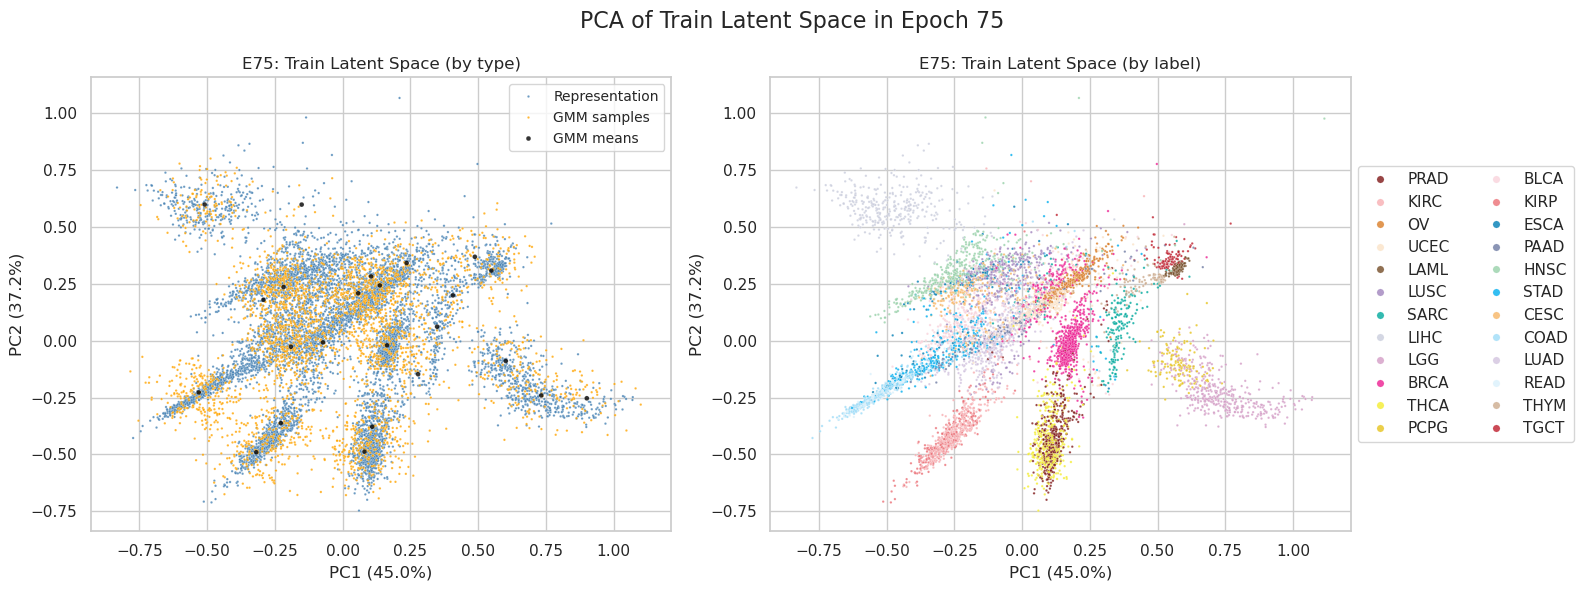

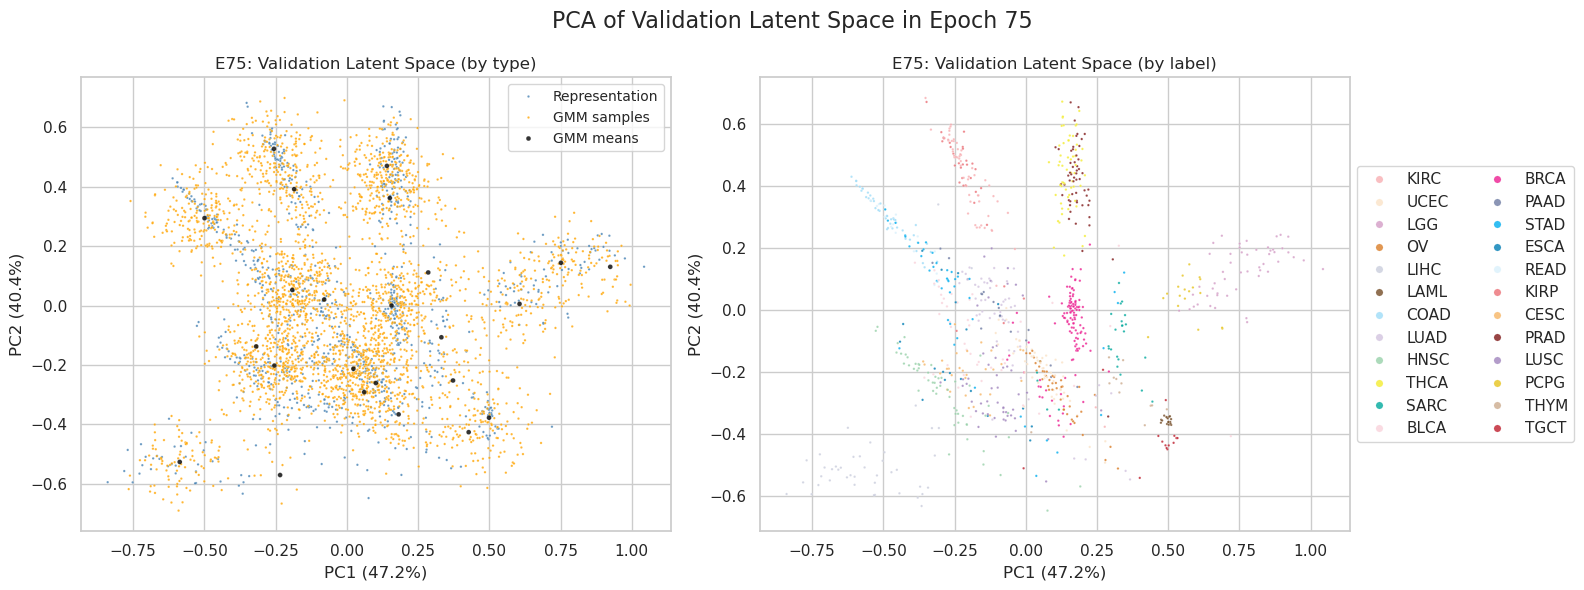

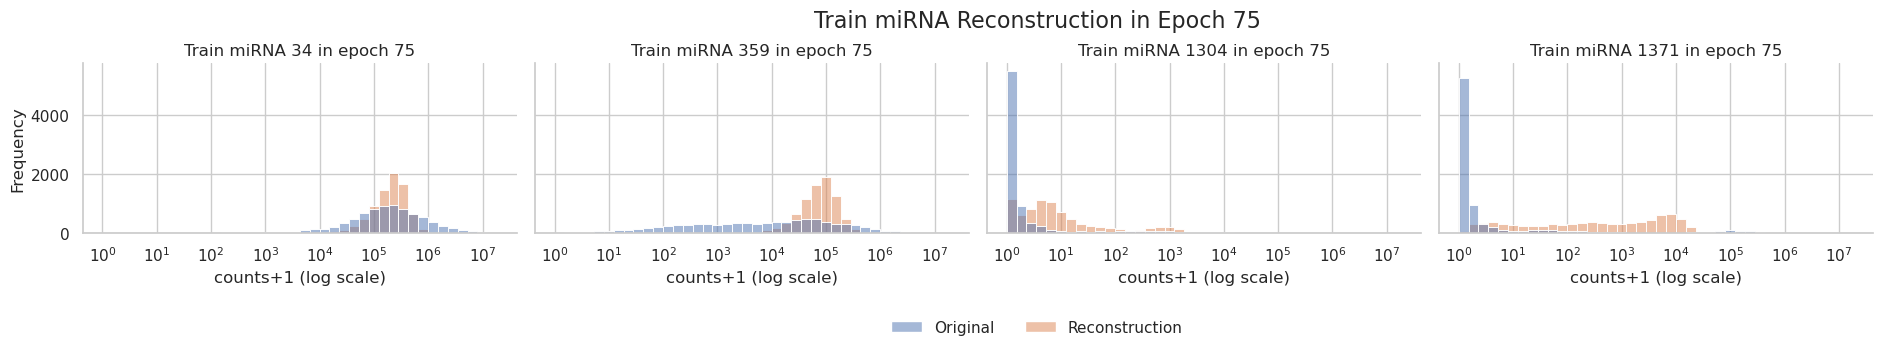

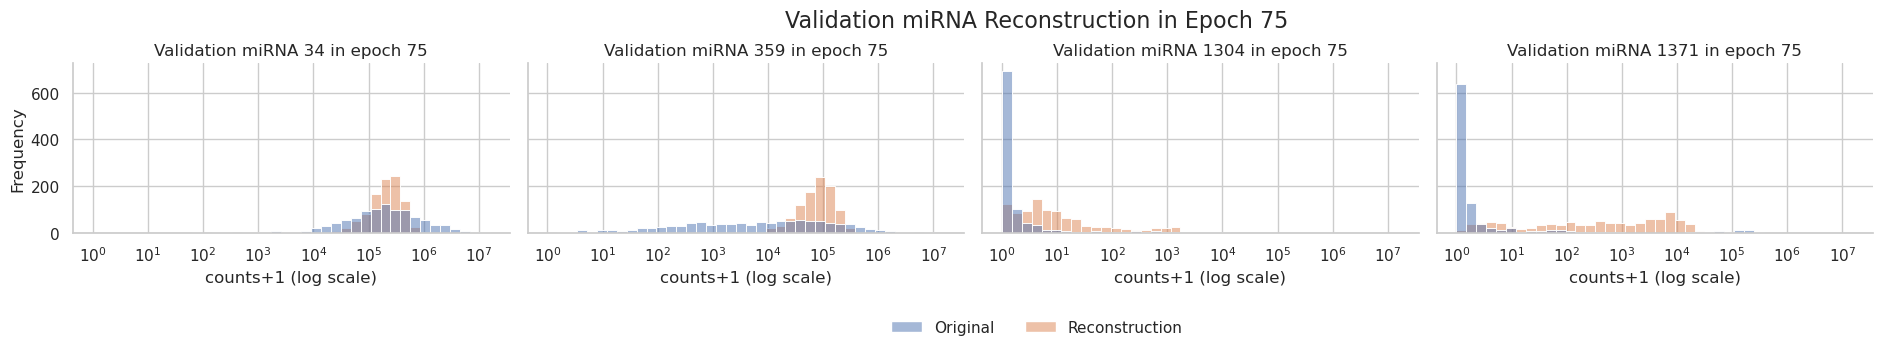

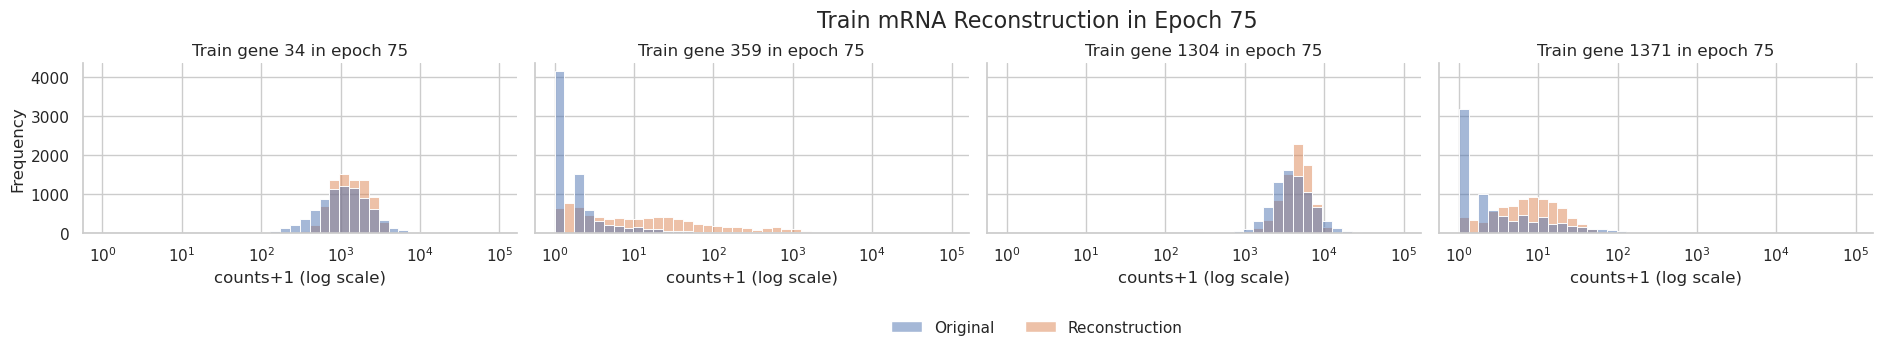

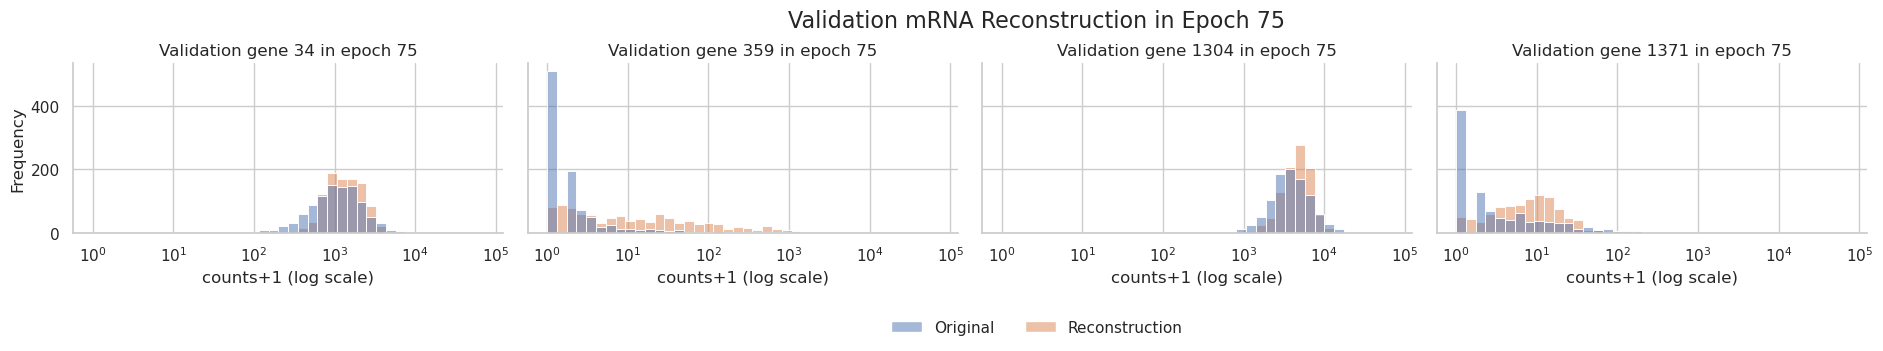

  5%|██████▌                                                                                                                   | 81/1500 [05:50<1:49:19,  4.62s/it]

80 train_loss: 11.244957534523738 train_recon_mirna: 2.096779113167852 train_recon_mrna: 6.964123733308581 train_gmm: 2.184054688047306 train_mse: 688404544.0 train_mae: 7044.39453125 train_r2: 0.14362776279449463 train_spearman: 0.10887929052114487 train_pearson: 0.47096091508865356 train_msle: 34.345035552978516
80 test_loss: 11.313156939305342 test_recon_mirna: 2.161844832026029 test_recon_mrna: 6.967849053725581 test_gmm: 2.1834630535537314 test_mse: 731837056.0 test_mae: 7449.46728515625 test_r2: 0.1437947154045105 test_spearman: 0.09695015102624893 test_pearson: 0.4806116819381714 test_msle: 34.27814865112305


  6%|██████▉                                                                                                                   | 86/1500 [06:09<1:33:41,  3.98s/it]

85 train_loss: 11.200376301032446 train_recon_mirna: 2.084783043212439 train_recon_mrna: 6.931050285365163 train_gmm: 2.1845429724548415 train_mse: 682080640.0 train_mae: 7450.83837890625 train_r2: 0.15149468183517456 train_spearman: 0.11018193513154984 train_pearson: 0.4516037702560425 train_msle: 35.52809143066406
85 test_loss: 11.28032133659185 test_recon_mirna: 2.160033929710077 test_recon_mrna: 6.935832474180765 test_gmm: 2.184454932701008 test_mse: 721996160.0 test_mae: 7838.44873046875 test_r2: 0.15530794858932495 test_spearman: 0.09016519039869308 test_pearson: 0.4664583206176758 test_msle: 35.534812927246094


  6%|███████▍                                                                                                                  | 91/1500 [06:31<1:39:43,  4.25s/it]

90 train_loss: 11.160208131359854 train_recon_mirna: 2.076151641813691 train_recon_mrna: 6.898763826656076 train_gmm: 2.185292662890086 train_mse: 680239040.0 train_mae: 7774.19384765625 train_r2: 0.15378564596176147 train_spearman: 0.11132510006427765 train_pearson: 0.4349094331264496 train_msle: 36.0431022644043
90 test_loss: 11.254152588843251 test_recon_mirna: 2.1643605329632822 test_recon_mrna: 6.904194635943954 test_gmm: 2.1855974199360135 test_mse: 720244288.0 test_mae: 8183.2822265625 test_r2: 0.15735751390457153 test_spearman: 0.08931092172861099 test_pearson: 0.44688063859939575 test_msle: 36.13312530517578


  6%|███████▊                                                                                                                  | 96/1500 [06:51<1:30:46,  3.88s/it]

95 train_loss: 11.125400889879998 train_recon_mirna: 2.0720082347081403 train_recon_mrna: 6.86714251287227 train_gmm: 2.1862501422995884 train_mse: 681903424.0 train_mae: 8107.2060546875 train_r2: 0.15171509981155396 train_spearman: 0.11343634128570557 train_pearson: 0.4168858826160431 train_msle: 36.82085037231445
95 test_loss: 11.22126453035755 test_recon_mirna: 2.161697316406841 test_recon_mrna: 6.8726130588641 test_gmm: 2.186954155086608 test_mse: 724830848.0 test_mae: 8533.1513671875 test_r2: 0.15199154615402222 test_spearman: 0.08906479179859161 test_pearson: 0.4209063649177551 test_msle: 36.88214111328125


  7%|████████▏                                                                                                                | 101/1500 [07:10<1:29:15,  3.83s/it]

100 train_loss: 11.091630804900934 train_recon_mirna: 2.0675385935573427 train_recon_mrna: 6.837002529890903 train_gmm: 2.1870896814526883 train_mse: 680594304.0 train_mae: 8182.12744140625 train_r2: 0.15334373712539673 train_spearman: 0.11463812738656998 train_pearson: 0.41482749581336975 train_msle: 36.65348815917969
100 test_loss: 11.184949162696494 test_recon_mirna: 2.1534923089421256 test_recon_mrna: 6.843667688918967 test_gmm: 2.1877891648354018 test_mse: 722709056.0 test_mae: 8617.44140625 test_r2: 0.1544739007949829 test_spearman: 0.08865991979837418 test_pearson: 0.4194120466709137 test_msle: 36.6269645690918


  7%|████████▌                                                                                                                | 106/1500 [07:29<1:26:19,  3.72s/it]

105 train_loss: 11.056240998246494 train_recon_mirna: 2.060240780288632 train_recon_mrna: 6.8082533723776715 train_gmm: 2.187746845580192 train_mse: 679705536.0 train_mae: 8265.5888671875 train_r2: 0.15444934368133545 train_spearman: 0.11856282502412796 train_pearson: 0.4128936529159546 train_msle: 36.786067962646484
105 test_loss: 11.142267998750174 test_recon_mirna: 2.1381420306375203 test_recon_mrna: 6.815788871260277 test_gmm: 2.1883370968523783 test_mse: 720844416.0 test_mae: 8666.0068359375 test_r2: 0.1566554307937622 test_spearman: 0.09129708260297775 test_pearson: 0.4197344183921814 test_msle: 36.773746490478516


  7%|████████▉                                                                                                                | 111/1500 [07:49<1:35:27,  4.12s/it]

110 train_loss: 11.020368769424996 train_recon_mirna: 2.050105083172264 train_recon_mrna: 6.781702647054838 train_gmm: 2.188561039197895 train_mse: 676559424.0 train_mae: 8128.28564453125 train_r2: 0.1583629846572876 train_spearman: 0.12172603607177734 train_pearson: 0.42102813720703125 train_msle: 35.934627532958984
110 test_loss: 11.104401731420435 test_recon_mirna: 2.1250678900760676 test_recon_mrna: 6.790591206800245 test_gmm: 2.1887426345441225 test_mse: 716115584.0 test_mae: 8537.287109375 test_r2: 0.1621878743171692 test_spearman: 0.09190884232521057 test_pearson: 0.4306287169456482 test_msle: 35.979148864746094


  8%|█████████▎                                                                                                               | 116/1500 [08:10<1:29:34,  3.88s/it]

115 train_loss: 10.9864950148948 train_recon_mirna: 2.0384960516561863 train_recon_mrna: 6.758545044644756 train_gmm: 2.1894539185938577 train_mse: 672823104.0 train_mae: 8036.17626953125 train_r2: 0.16301101446151733 train_spearman: 0.12642060220241547 train_pearson: 0.4290105104446411 train_msle: 35.39824295043945
115 test_loss: 11.066436496218166 test_recon_mirna: 2.108542101171669 test_recon_mrna: 6.768810805201402 test_gmm: 2.1890835898450964 test_mse: 716358912.0 test_mae: 8454.1982421875 test_r2: 0.16190320253372192 test_spearman: 0.09277525544166565 test_pearson: 0.43075498938560486 test_msle: 35.32485580444336


  8%|█████████▊                                                                                                               | 121/1500 [08:29<1:26:52,  3.78s/it]

120 train_loss: 10.956066460731735 train_recon_mirna: 2.027058585379162 train_recon_mrna: 6.738465508049887 train_gmm: 2.1905423673026867 train_mse: 668800128.0 train_mae: 7958.5146484375 train_r2: 0.16801559925079346 train_spearman: 0.13211964070796967 train_pearson: 0.4372157156467438 train_msle: 34.928375244140625
120 test_loss: 11.03555113130684 test_recon_mirna: 2.0956549137853515 test_recon_mrna: 6.750039170651876 test_gmm: 2.189857046869614 test_mse: 707400384.0 test_mae: 8325.935546875 test_r2: 0.1723841428756714 test_spearman: 0.09976484626531601 test_pearson: 0.44871023297309875 test_msle: 34.78425598144531


  8%|██████████▏                                                                                                              | 126/1500 [08:47<1:26:10,  3.76s/it]

125 train_loss: 10.929043333023856 train_recon_mirna: 2.016536729440391 train_recon_mrna: 6.720850455719205 train_gmm: 2.19165614786426 train_mse: 660535104.0 train_mae: 7695.06103515625 train_r2: 0.178297221660614 train_spearman: 0.1397179514169693 train_pearson: 0.4594280421733856 train_msle: 33.708248138427734
125 test_loss: 11.010725407932554 test_recon_mirna: 2.0865770430378374 test_recon_mrna: 6.733601378806946 test_gmm: 2.1905469860877713 test_mse: 702744640.0 test_mae: 8165.52099609375 test_r2: 0.17783111333847046 test_spearman: 0.10392125695943832 test_pearson: 0.4611130356788635 test_msle: 33.822059631347656


  9%|██████████▌                                                                                                              | 131/1500 [09:06<1:26:48,  3.80s/it]

130 train_loss: 10.904818637085967 train_recon_mirna: 2.0070441640944976 train_recon_mrna: 6.704936925948404 train_gmm: 2.192837547043065 train_mse: 651003584.0 train_mae: 7247.97021484375 train_r2: 0.19015437364578247 train_spearman: 0.14931638538837433 train_pearson: 0.49449771642684937 train_msle: 31.710268020629883
130 test_loss: 10.985048109452917 test_recon_mirna: 2.0749453909599795 test_recon_mrna: 6.718591069761897 test_gmm: 2.191511648731041 test_mse: 693841472.0 test_mae: 7686.71142578125 test_r2: 0.1882472038269043 test_spearman: 0.11390865594148636 test_pearson: 0.4954361021518707 test_msle: 31.761051177978516


  9%|██████████▉                                                                                                              | 136/1500 [09:26<1:27:32,  3.85s/it]

135 train_loss: 10.882097550303262 train_recon_mirna: 1.9982051850808278 train_recon_mrna: 6.689917921302282 train_gmm: 2.1939744439201534 train_mse: 641909888.0 train_mae: 6963.8720703125 train_r2: 0.20146697759628296 train_spearman: 0.16347955167293549 train_pearson: 0.5243042707443237 train_msle: 30.372730255126953
135 test_loss: 10.963719283354997 test_recon_mirna: 2.0667699856121575 test_recon_mrna: 6.704346834422001 test_gmm: 2.1926024633208376 test_mse: 685099968.0 test_mae: 7426.62744140625 test_r2: 0.19847428798675537 test_spearman: 0.12925173342227936 test_pearson: 0.5216742753982544 test_msle: 30.38138198852539


  9%|███████████▎                                                                                                             | 141/1500 [09:44<1:23:26,  3.68s/it]

140 train_loss: 10.860912603900296 train_recon_mirna: 1.9903097724486707 train_recon_mrna: 6.675596373450042 train_gmm: 2.195006458001582 train_mse: 632495808.0 train_mae: 6607.95361328125 train_r2: 0.21317797899246216 train_spearman: 0.17901825904846191 train_pearson: 0.5610701441764832 train_msle: 28.845157623291016
140 test_loss: 10.938535565794869 test_recon_mirna: 2.0548490502797865 test_recon_mrna: 6.6904102543659105 test_gmm: 2.1932762611491725 test_mse: 673520128.0 test_mae: 7048.60595703125 test_r2: 0.21202200651168823 test_spearman: 0.14826080203056335 test_pearson: 0.561806857585907 test_msle: 28.853239059448242


 10%|███████████▊                                                                                                             | 146/1500 [10:03<1:26:09,  3.82s/it]

145 train_loss: 10.840831177835621 train_recon_mirna: 1.982955845410557 train_recon_mrna: 6.661867550532107 train_gmm: 2.196007781892958 train_mse: 625486976.0 train_mae: 6065.52294921875 train_r2: 0.22189688682556152 train_spearman: 0.19153812527656555 train_pearson: 0.6154021620750427 train_msle: 26.173477172851562
145 test_loss: 10.919743348695032 test_recon_mirna: 2.0473344714767157 test_recon_mrna: 6.678117139186173 test_gmm: 2.194291738032144 test_mse: 668549760.0 test_mae: 6534.90869140625 test_r2: 0.21783703565597534 test_spearman: 0.16159500181674957 test_pearson: 0.6081587672233582 test_msle: 26.375394821166992


 10%|████████████                                                                                                             | 150/1500 [10:18<1:23:28,  3.71s/it]

150 train_loss: 10.822084990944075 train_recon_mirna: 1.9762068032804483 train_recon_mrna: 6.648858269426109 train_gmm: 2.1970199182375194 train_mse: 619394368.0 train_mae: 5666.80126953125 train_r2: 0.22947615385055542 train_spearman: 0.20485836267471313 train_pearson: 0.6610442996025085 train_msle: 23.98349952697754
150 test_loss: 10.902160025697741 test_recon_mirna: 2.041337120914078 test_recon_mrna: 6.66527738976729 test_gmm: 2.1955455150163736 test_mse: 666046656.0 test_mae: 6067.0712890625 test_r2: 0.22076553106307983 test_spearman: 0.17636847496032715 test_pearson: 0.6538950800895691 test_msle: 23.845922470092773


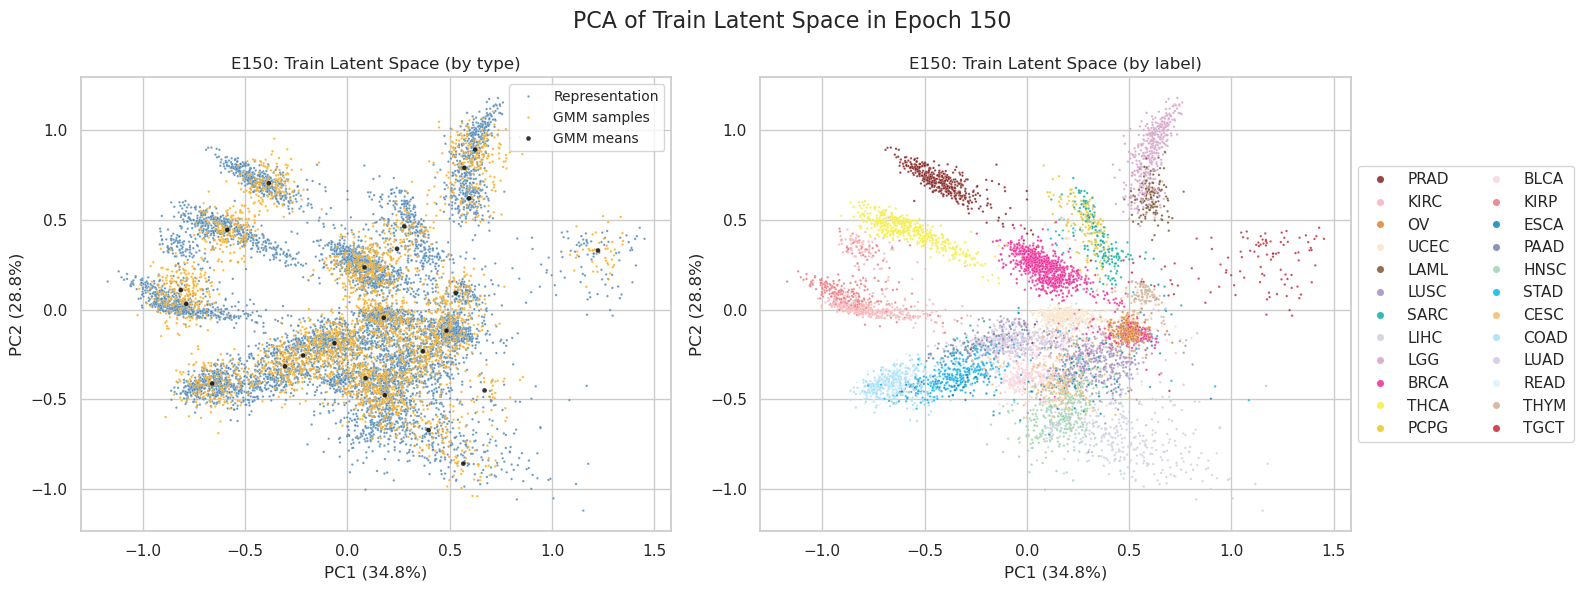

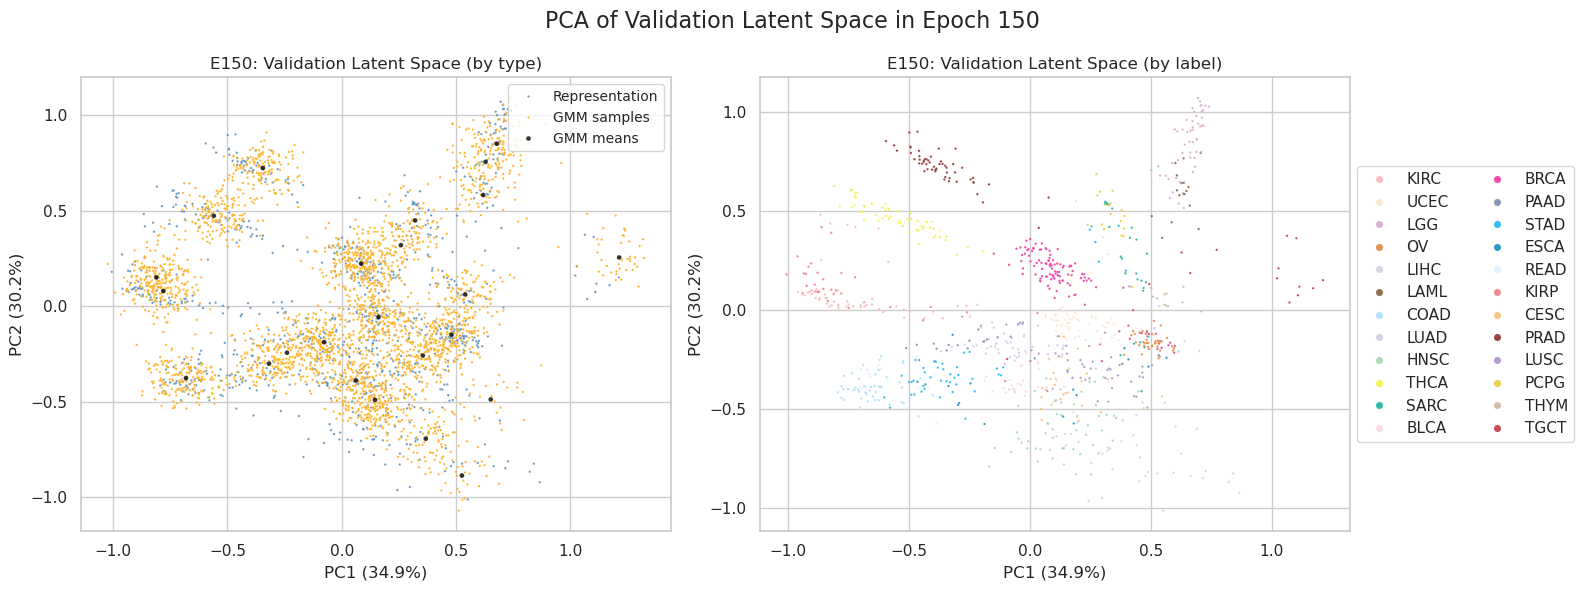

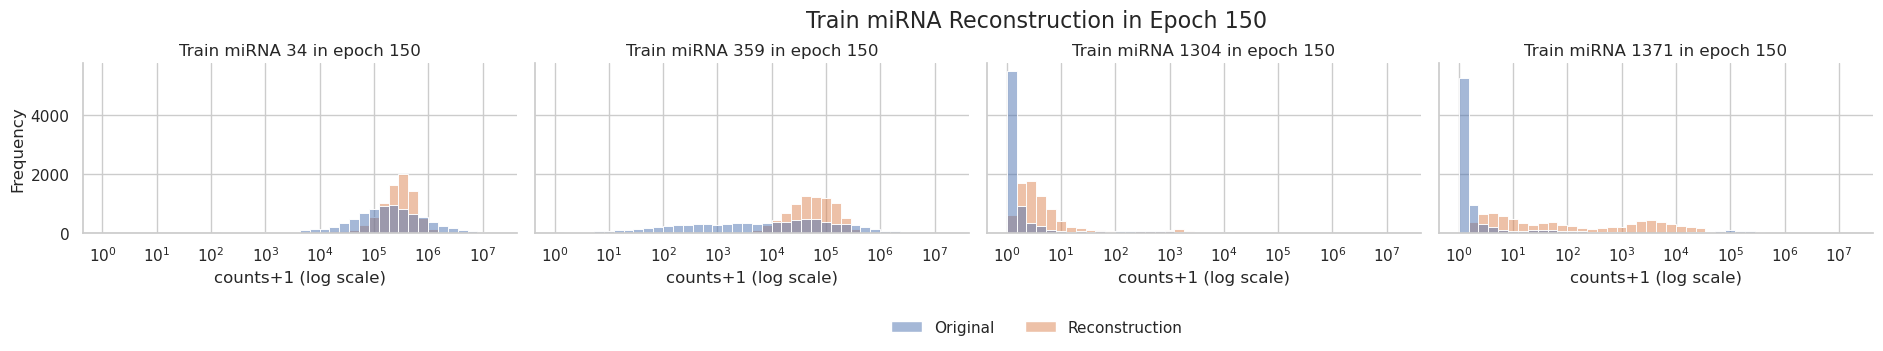

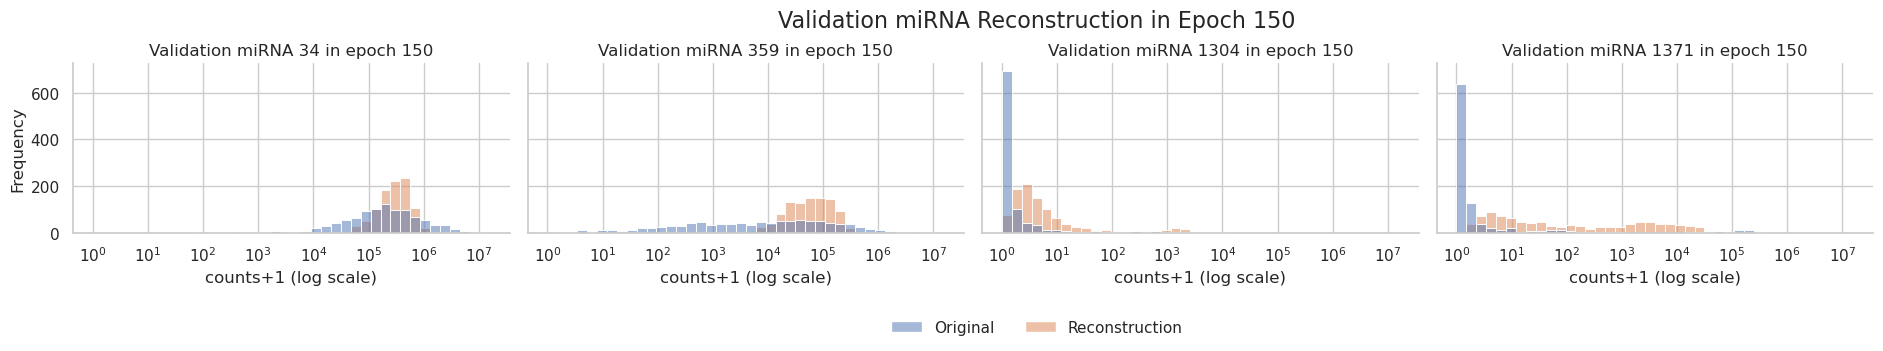

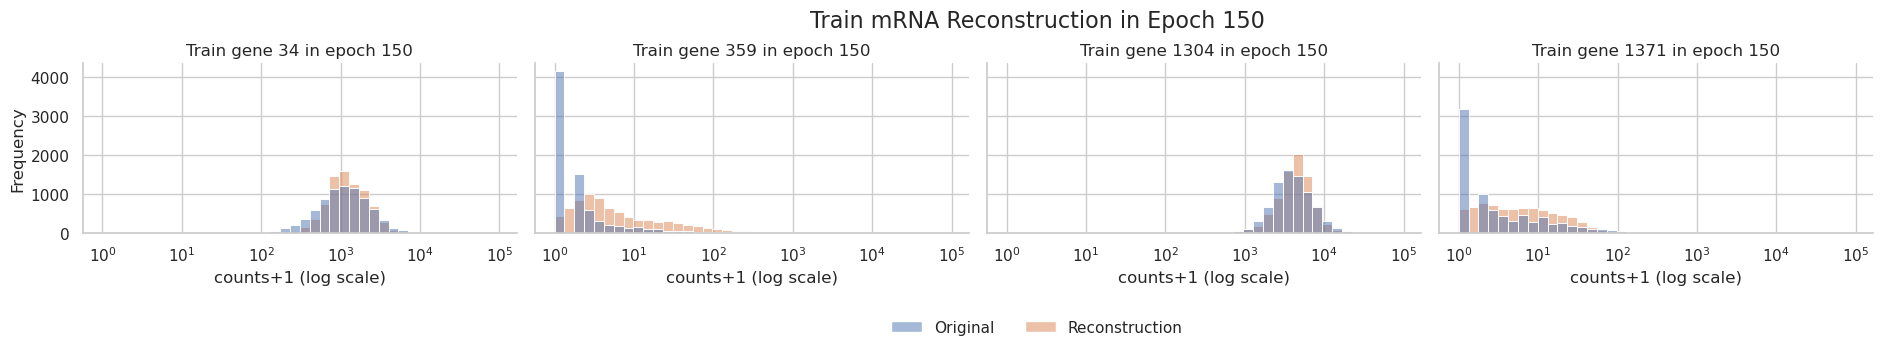

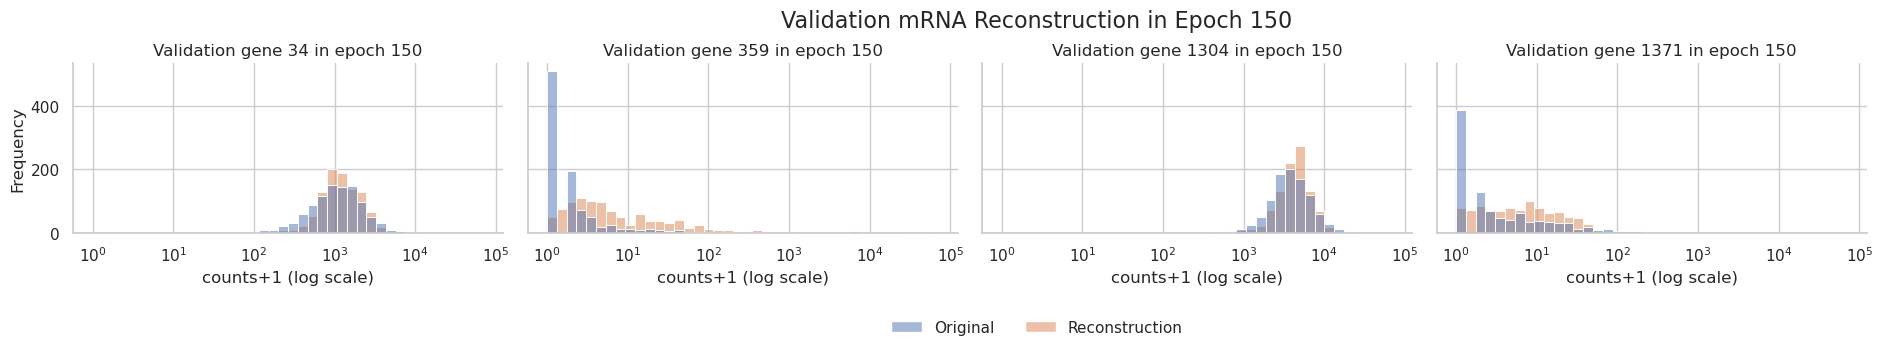

 10%|████████████▌                                                                                                            | 156/1500 [10:56<1:41:07,  4.51s/it]

155 train_loss: 10.804256734946861 train_recon_mirna: 1.9697638868130418 train_recon_mrna: 6.636437173083097 train_gmm: 2.1980556750507225 train_mse: 613168960.0 train_mae: 5383.94873046875 train_r2: 0.23722052574157715 train_spearman: 0.21797315776348114 train_pearson: 0.6997919082641602 train_msle: 22.709604263305664
155 test_loss: 10.88665180012445 test_recon_mirna: 2.0367385741576776 test_recon_mrna: 6.65350361640326 test_gmm: 2.1964096095635126 test_mse: 657055808.0 test_mae: 5793.31640625 test_r2: 0.2312842607498169 test_spearman: 0.19114729762077332 test_pearson: 0.6940366625785828 test_msle: 22.628828048706055


 11%|████████████▉                                                                                                            | 161/1500 [11:16<1:27:35,  3.93s/it]

160 train_loss: 10.787103249626826 train_recon_mirna: 1.9635785653156688 train_recon_mrna: 6.624472825836434 train_gmm: 2.1990518584747236 train_mse: 611071552.0 train_mae: 4974.8896484375 train_r2: 0.23982971906661987 train_spearman: 0.22856955230236053 train_pearson: 0.7507532835006714 train_msle: 19.5297794342041
160 test_loss: 10.874161501093432 test_recon_mirna: 2.033399298899248 test_recon_mrna: 6.643498193016314 test_gmm: 2.1972640091778697 test_mse: 656946432.0 test_mae: 5413.2119140625 test_r2: 0.23141223192214966 test_spearman: 0.20083731412887573 test_pearson: 0.7380720376968384 test_msle: 19.68896484375


 11%|█████████████▍                                                                                                           | 166/1500 [11:35<1:24:54,  3.82s/it]

165 train_loss: 10.77079030056042 train_recon_mirna: 1.9577745422828925 train_recon_mrna: 6.612938612323957 train_gmm: 2.200077145953572 train_mse: 608094336.0 train_mae: 4742.7470703125 train_r2: 0.24353325366973877 train_spearman: 0.23860439658164978 train_pearson: 0.7796847820281982 train_msle: 17.41082191467285
165 test_loss: 10.859660054726854 test_recon_mirna: 2.0300311719551525 test_recon_mrna: 6.631434732317116 test_gmm: 2.1981941504545848 test_mse: 650046080.0 test_mae: 5132.83447265625 test_r2: 0.23948520421981812 test_spearman: 0.21128377318382263 test_pearson: 0.7793933153152466 test_msle: 17.510175704956055


 11%|█████████████▊                                                                                                           | 171/1500 [11:53<1:19:45,  3.60s/it]

170 train_loss: 10.755025206232284 train_recon_mirna: 1.9521106449232337 train_recon_mrna: 6.601728159541908 train_gmm: 2.201186401767142 train_mse: 609777088.0 train_mae: 4548.658203125 train_r2: 0.24143999814987183 train_spearman: 0.25120583176612854 train_pearson: 0.8088107705116272 train_msle: 15.340296745300293
170 test_loss: 10.846782057806331 test_recon_mirna: 2.026012852236451 test_recon_mrna: 6.621393215878826 test_gmm: 2.1993759896910547 test_mse: 653957504.0 test_mae: 4943.13330078125 test_r2: 0.2349090576171875 test_spearman: 0.2250135838985443 test_pearson: 0.8073227405548096 test_msle: 15.599111557006836


 12%|██████████████▏                                                                                                          | 176/1500 [12:12<1:22:08,  3.72s/it]

175 train_loss: 10.739508003839406 train_recon_mirna: 1.9463814322622197 train_recon_mrna: 6.590810462640706 train_gmm: 2.2023161089364813 train_mse: 607891904.0 train_mae: 4411.32861328125 train_r2: 0.24378514289855957 train_spearman: 0.2633804678916931 train_pearson: 0.8277795910835266 train_msle: 13.474273681640625
175 test_loss: 10.831904224707603 test_recon_mirna: 2.0203219809800492 test_recon_mrna: 6.611229119266162 test_gmm: 2.2003531244613925 test_mse: 656098688.0 test_mae: 4810.01611328125 test_r2: 0.23240399360656738 test_spearman: 0.23994813859462738 test_pearson: 0.8239657282829285 test_msle: 13.82430648803711


 12%|██████████████▌                                                                                                          | 181/1500 [12:32<1:24:00,  3.82s/it]

180 train_loss: 10.724698814200169 train_recon_mirna: 1.9410016042455613 train_recon_mrna: 6.580198844042246 train_gmm: 2.203498365912361 train_mse: 608252928.0 train_mae: 4306.169921875 train_r2: 0.24333608150482178 train_spearman: 0.28070858120918274 train_pearson: 0.8420019745826721 train_msle: 11.780219078063965
180 test_loss: 10.818778678185815 test_recon_mirna: 2.016224243284311 test_recon_mrna: 6.600680047567394 test_gmm: 2.201874387334109 test_mse: 653004928.0 test_mae: 4664.1181640625 test_r2: 0.23602360486984253 test_spearman: 0.2626664638519287 test_pearson: 0.8474774956703186 test_msle: 11.994030952453613


 12%|███████████████                                                                                                          | 186/1500 [12:53<1:30:56,  4.15s/it]

185 train_loss: 10.71009403555463 train_recon_mirna: 1.9355551559793855 train_recon_mrna: 6.569774807240574 train_gmm: 2.2047640723346698 train_mse: 607782464.0 train_mae: 4233.7275390625 train_r2: 0.24392127990722656 train_spearman: 0.2986949682235718 train_pearson: 0.8496735095977783 train_msle: 10.601451873779297
185 test_loss: 10.806889235200307 test_recon_mirna: 2.013223284776069 test_recon_mrna: 6.590484362986717 test_gmm: 2.2031815874375216 test_mse: 655040000.0 test_mae: 4593.91015625 test_r2: 0.23364263772964478 test_spearman: 0.2762129604816437 test_pearson: 0.8544581532478333 test_msle: 11.00866413116455


 13%|███████████████▍                                                                                                         | 191/1500 [13:13<1:24:30,  3.87s/it]

190 train_loss: 10.696350591678412 train_recon_mirna: 1.9304933119799217 train_recon_mrna: 6.559696023279011 train_gmm: 2.2061612564194797 train_mse: 606244992.0 train_mae: 4181.83984375 train_r2: 0.2458338737487793 train_spearman: 0.3145279884338379 train_pearson: 0.8543716073036194 train_msle: 9.745965957641602
190 test_loss: 10.795142152093927 test_recon_mirna: 2.009872816915729 test_recon_mrna: 6.581032750541435 test_gmm: 2.2042365846367633 test_mse: 649966144.0 test_mae: 4528.9638671875 test_r2: 0.23957878351211548 test_spearman: 0.28816697001457214 test_pearson: 0.8622891306877136 test_msle: 10.273540496826172


 13%|███████████████▊                                                                                                         | 196/1500 [13:32<1:25:05,  3.92s/it]

195 train_loss: 10.683046284650088 train_recon_mirna: 1.9256164131815012 train_recon_mrna: 6.550002803375623 train_gmm: 2.2074270680929633 train_mse: 604545024.0 train_mae: 4137.56103515625 train_r2: 0.24794858694076538 train_spearman: 0.3256613314151764 train_pearson: 0.8568707704544067 train_msle: 8.768279075622559
195 test_loss: 10.785064242146381 test_recon_mirna: 2.0075623509356184 test_recon_mrna: 6.571872030279189 test_gmm: 2.2056298609315754 test_mse: 649494912.0 test_mae: 4481.033203125 test_r2: 0.24013006687164307 test_spearman: 0.2954804003238678 test_pearson: 0.8604886531829834 test_msle: 9.378700256347656


 13%|████████████████▏                                                                                                        | 201/1500 [13:51<1:22:34,  3.81s/it]

200 train_loss: 10.670186420181976 train_recon_mirna: 1.9208957786806 train_recon_mrna: 6.5406294591787235 train_gmm: 2.2086611823226527 train_mse: 600637312.0 train_mae: 4102.8095703125 train_r2: 0.2528098225593567 train_spearman: 0.3306538164615631 train_pearson: 0.856923520565033 train_msle: 8.27841567993164
200 test_loss: 10.777614395528985 test_recon_mirna: 2.007482342193574 test_recon_mrna: 6.5631058191166085 test_gmm: 2.207026234218804 test_mse: 646339904.0 test_mae: 4437.650390625 test_r2: 0.24382126331329346 test_spearman: 0.2982669770717621 test_pearson: 0.8649511933326721 test_msle: 8.73663330078125


 14%|████████████████▌                                                                                                        | 206/1500 [14:12<1:29:00,  4.13s/it]

205 train_loss: 10.657645125800407 train_recon_mirna: 1.9162232745018903 train_recon_mrna: 6.53150051771056 train_gmm: 2.209921333587957 train_mse: 597192256.0 train_mae: 4070.548095703125 train_r2: 0.25709545612335205 train_spearman: 0.3371029794216156 train_pearson: 0.8576039671897888 train_msle: 7.7717604637146
205 test_loss: 10.767252484084086 test_recon_mirna: 2.004442057895737 test_recon_mrna: 6.554548727636124 test_gmm: 2.2082616985522234 test_mse: 640625856.0 test_mae: 4394.05029296875 test_r2: 0.25050634145736694 test_spearman: 0.30106958746910095 test_pearson: 0.8633127808570862 test_msle: 8.245285034179688


 14%|█████████████████                                                                                                        | 211/1500 [14:31<1:23:40,  3.89s/it]

210 train_loss: 10.645641845577533 train_recon_mirna: 1.9118684278537272 train_recon_mrna: 6.522633497611975 train_gmm: 2.2111399201118322 train_mse: 591580800.0 train_mae: 4034.03076171875 train_r2: 0.2640761137008667 train_spearman: 0.3446245491504669 train_pearson: 0.8573063611984253 train_msle: 7.60270357131958
210 test_loss: 10.759022850637304 test_recon_mirna: 2.0032003496817916 test_recon_mrna: 6.546330774638078 test_gmm: 2.2094917263174336 test_mse: 639340160.0 test_mae: 4370.36328125 test_r2: 0.2520105242729187 test_spearman: 0.30576708912849426 test_pearson: 0.8642705678939819 test_msle: 8.049820899963379


 14%|█████████████████▍                                                                                                       | 216/1500 [14:50<1:20:39,  3.77s/it]

215 train_loss: 10.634165586562409 train_recon_mirna: 1.9078486224028677 train_recon_mrna: 6.5140245236862375 train_gmm: 2.2122924404733038 train_mse: 589664192.0 train_mae: 4012.45947265625 train_r2: 0.2664602994918823 train_spearman: 0.3480091989040375 train_pearson: 0.8564543724060059 train_msle: 7.148768424987793
215 test_loss: 10.750973763069746 test_recon_mirna: 2.0008384392461096 test_recon_mrna: 6.539054436441053 test_gmm: 2.211080887382584 test_mse: 634021312.0 test_mae: 4339.76904296875 test_r2: 0.2582332491874695 test_spearman: 0.3038857579231262 test_pearson: 0.8653455376625061 test_msle: 7.730504512786865


 15%|█████████████████▊                                                                                                       | 221/1500 [15:09<1:22:49,  3.89s/it]

220 train_loss: 10.623084191978787 train_recon_mirna: 1.9039947230891614 train_recon_mrna: 6.505598352257178 train_gmm: 2.2134911166324476 train_mse: 580524160.0 train_mae: 3975.724853515625 train_r2: 0.27783048152923584 train_spearman: 0.35115718841552734 train_pearson: 0.855084240436554 train_msle: 7.579380512237549
220 test_loss: 10.738164071396989 test_recon_mirna: 1.9965127301237273 test_recon_mrna: 6.529635145349442 test_gmm: 2.212016195923819 test_mse: 628329728.0 test_mae: 4332.92822265625 test_r2: 0.264892041683197 test_spearman: 0.3099823296070099 test_pearson: 0.8635653257369995 test_msle: 8.210152626037598


 15%|██████████████████▏                                                                                                      | 225/1500 [15:27<1:32:40,  4.36s/it]

225 train_loss: 10.612311511054969 train_recon_mirna: 1.9003107795451606 train_recon_mrna: 6.497433296366424 train_gmm: 2.214567435143384 train_mse: 579506944.0 train_mae: 3951.035888671875 train_r2: 0.2790958881378174 train_spearman: 0.35389116406440735 train_pearson: 0.8530622720718384 train_msle: 6.721312999725342
225 test_loss: 10.732019326386792 test_recon_mirna: 1.9969873379579484 test_recon_mrna: 6.521735219803801 test_gmm: 2.213296768625043 test_mse: 620413440.0 test_mae: 4281.13818359375 test_r2: 0.27415359020233154 test_spearman: 0.30801233649253845 test_pearson: 0.8625398874282837 test_msle: 7.39921236038208


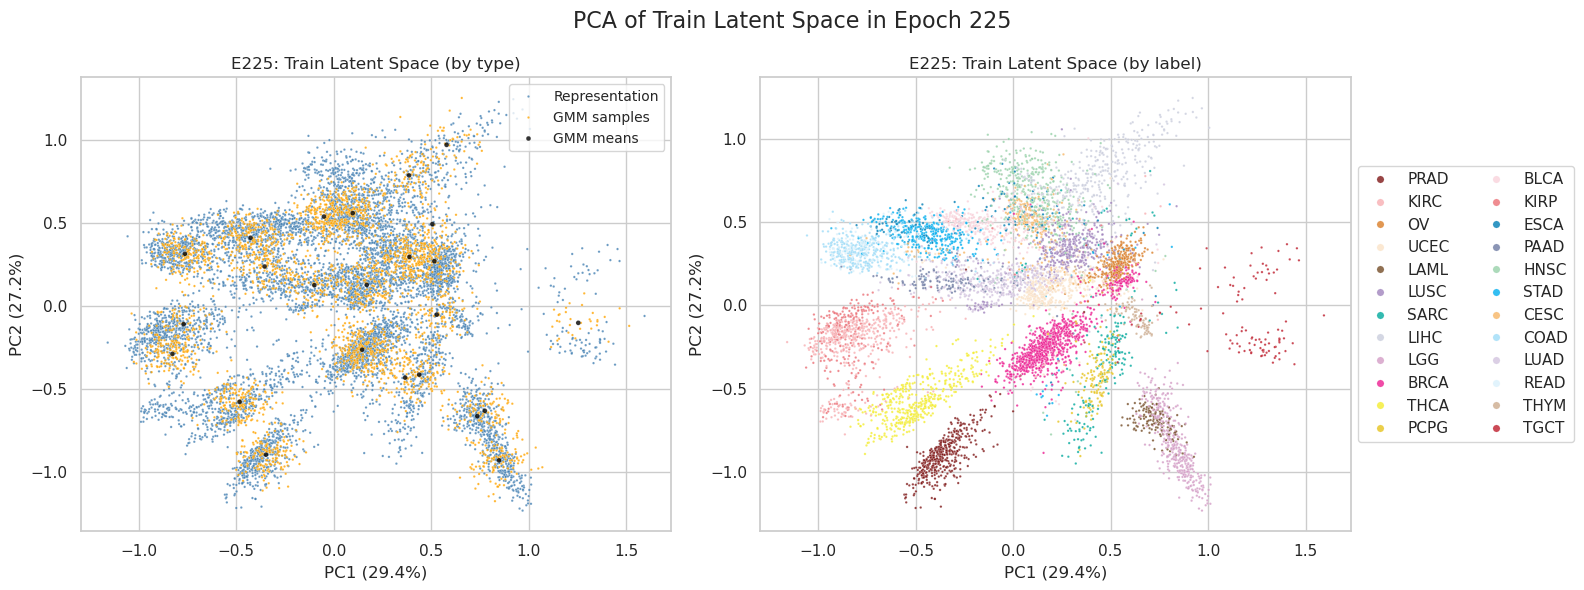

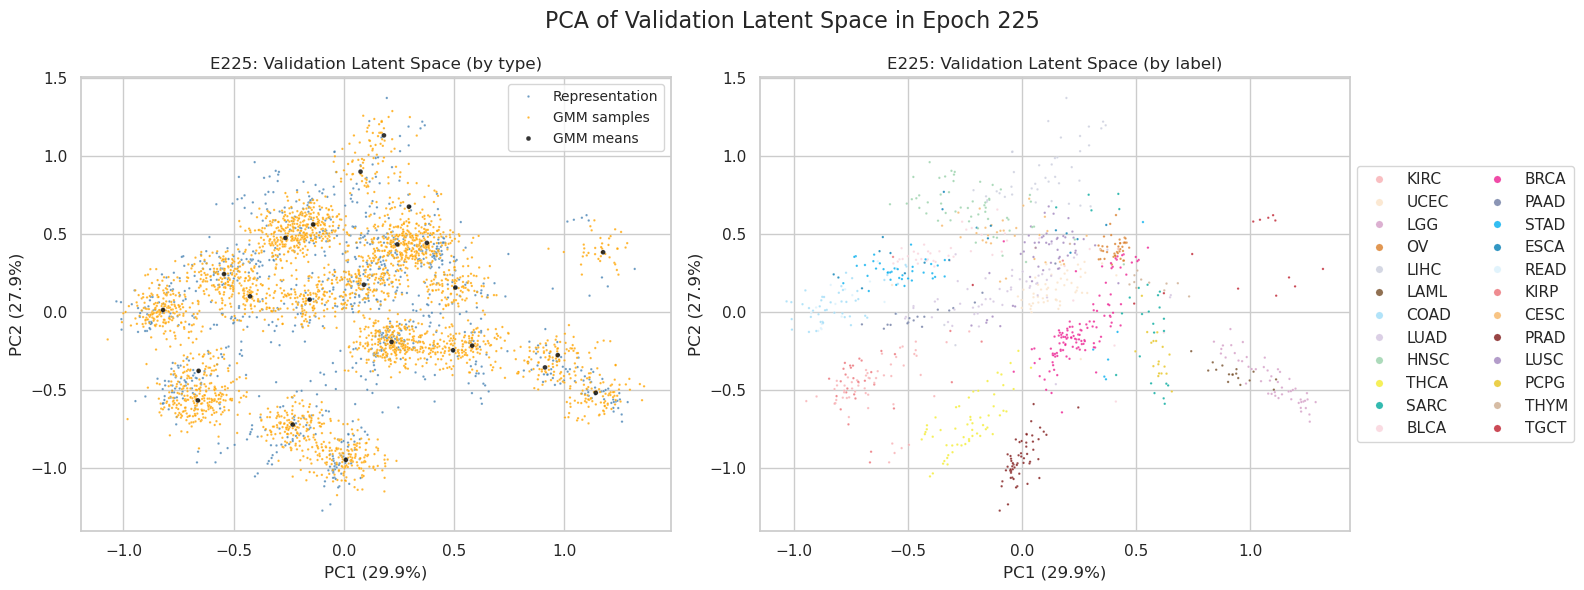

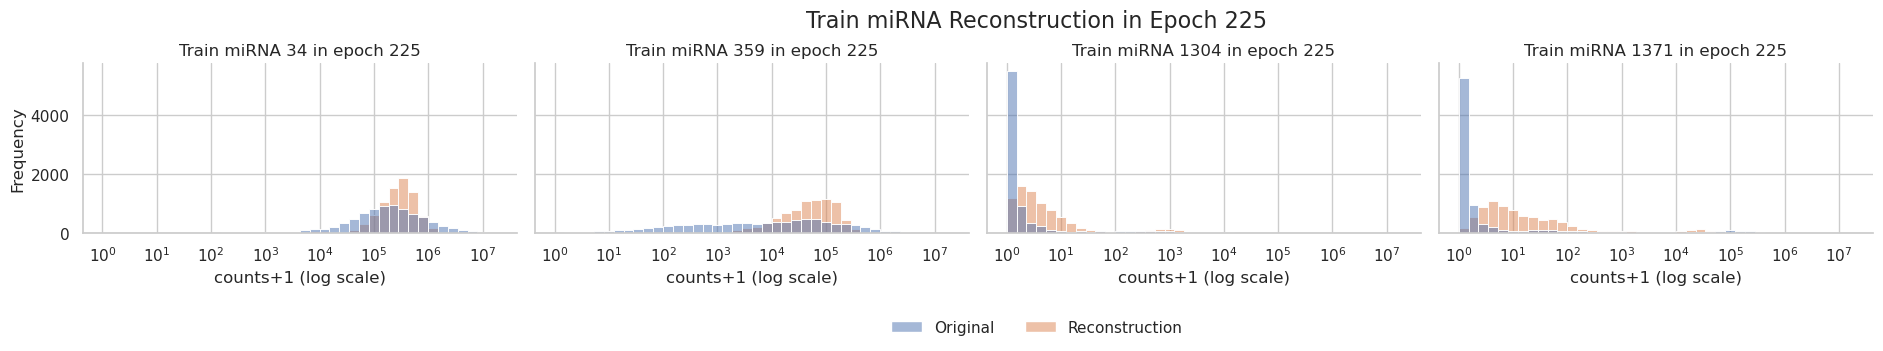

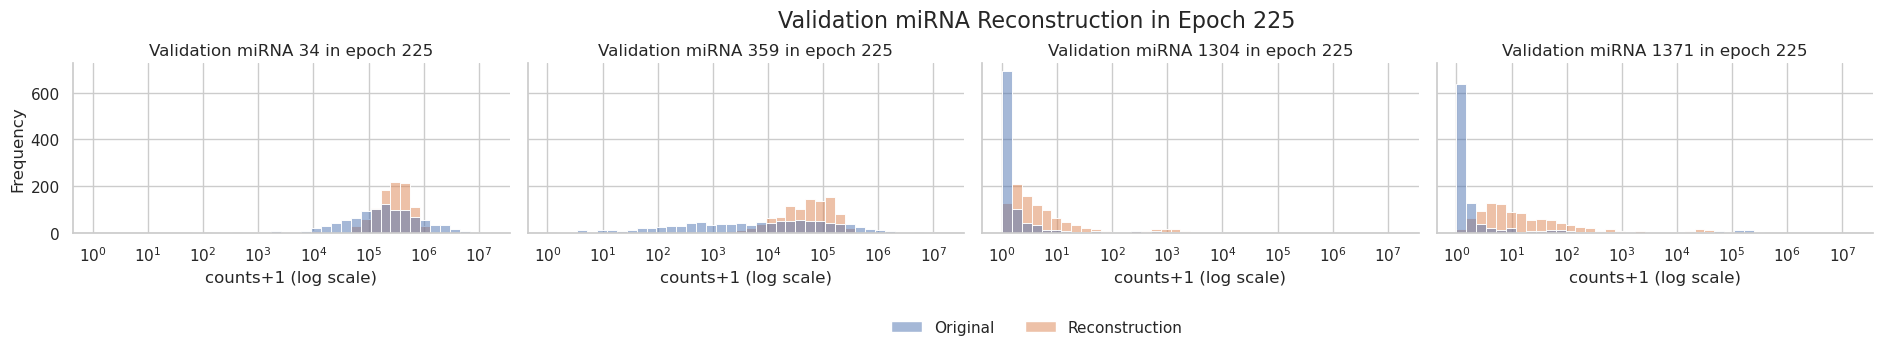

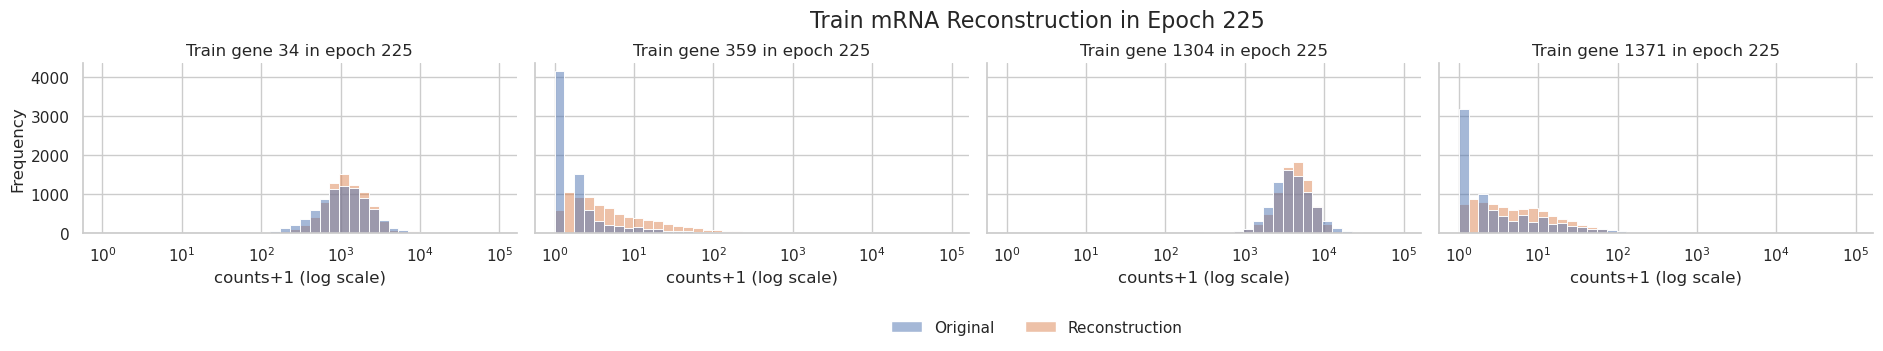

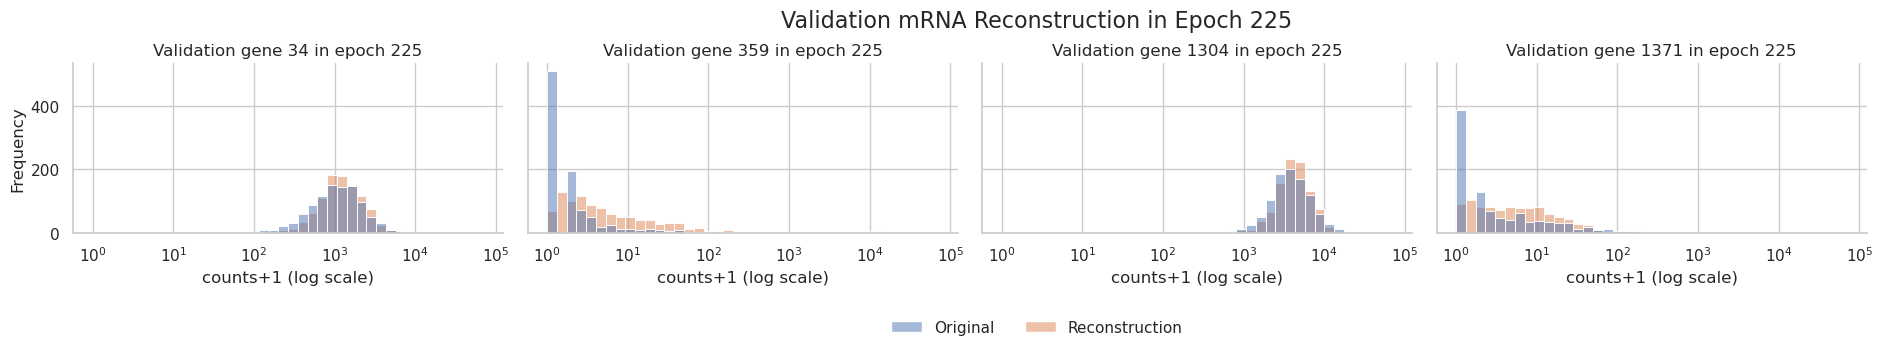

 15%|██████████████████▋                                                                                                      | 231/1500 [16:07<1:38:08,  4.64s/it]

230 train_loss: 10.60199081956381 train_recon_mirna: 1.8967777277462228 train_recon_mrna: 6.489556289122617 train_gmm: 2.215656802694969 train_mse: 571923968.0 train_mae: 3918.37939453125 train_r2: 0.28852909803390503 train_spearman: 0.3582107424736023 train_pearson: 0.8508293628692627 train_msle: 6.92081880569458
230 test_loss: 10.721364081181765 test_recon_mirna: 1.9926552581534513 test_recon_mrna: 6.514703937186147 test_gmm: 2.2140048858421664 test_mse: 617000768.0 test_mae: 4266.2392578125 test_r2: 0.27814626693725586 test_spearman: 0.31447678804397583 test_pearson: 0.8632602095603943 test_msle: 7.4916229248046875


 16%|███████████████████                                                                                                      | 236/1500 [16:26<1:23:17,  3.95s/it]

235 train_loss: 10.591757676741754 train_recon_mirna: 1.8932801272054283 train_recon_mrna: 6.4819335478512965 train_gmm: 2.2165440016850293 train_mse: 570083072.0 train_mae: 3897.073974609375 train_r2: 0.2908191680908203 train_spearman: 0.36330386996269226 train_pearson: 0.8507101535797119 train_msle: 6.394036293029785
235 test_loss: 10.713687394773567 test_recon_mirna: 1.991966298421016 test_recon_mrna: 6.506945345533867 test_gmm: 2.214775750818683 test_mse: 616965312.0 test_mae: 4254.07763671875 test_r2: 0.27818769216537476 test_spearman: 0.3114544153213501 test_pearson: 0.8640931248664856 test_msle: 7.041159152984619


 16%|███████████████████▍                                                                                                     | 241/1500 [16:44<1:18:22,  3.74s/it]

240 train_loss: 10.581975278804624 train_recon_mirna: 1.889982232656518 train_recon_mrna: 6.474540160573477 train_gmm: 2.2174528855746276 train_mse: 565113344.0 train_mae: 3870.7109375 train_r2: 0.2970014810562134 train_spearman: 0.3653014302253723 train_pearson: 0.848503828048706 train_msle: 6.464616298675537
240 test_loss: 10.703846210152967 test_recon_mirna: 1.987606516527625 test_recon_mrna: 6.500654887200833 test_gmm: 2.2155848064245087 test_mse: 605503360.0 test_mae: 4208.1435546875 test_r2: 0.29159754514694214 test_spearman: 0.31952208280563354 test_pearson: 0.8650804758071899 test_msle: 6.986471652984619


 16%|███████████████████▊                                                                                                     | 246/1500 [17:04<1:20:46,  3.86s/it]

245 train_loss: 10.572291525898793 train_recon_mirna: 1.8867153074129586 train_recon_mrna: 6.467306711148902 train_gmm: 2.218269507336933 train_mse: 558481024.0 train_mae: 3839.19384765625 train_r2: 0.3052520751953125 train_spearman: 0.36548373103141785 train_pearson: 0.8476123809814453 train_msle: 6.3485870361328125
245 test_loss: 10.696065916055066 test_recon_mirna: 1.9863858044214002 test_recon_mrna: 6.493224276092041 test_gmm: 2.2164558355416237 test_mse: 600125760.0 test_mae: 4188.13525390625 test_r2: 0.29788899421691895 test_spearman: 0.31873220205307007 test_pearson: 0.8584316968917847 test_msle: 6.996054649353027


 17%|████████████████████▏                                                                                                    | 251/1500 [17:24<1:21:14,  3.90s/it]

250 train_loss: 10.563041037909468 train_recon_mirna: 1.883612575998903 train_recon_mrna: 6.460381560976676 train_gmm: 2.2190469009338893 train_mse: 558920896.0 train_mae: 3830.59423828125 train_r2: 0.30470484495162964 train_spearman: 0.3690132200717926 train_pearson: 0.8473077416419983 train_msle: 6.004594802856445
250 test_loss: 10.687399788735137 test_recon_mirna: 1.9840493607475547 test_recon_mrna: 6.486561834075999 test_gmm: 2.2167885939115823 test_mse: 600921472.0 test_mae: 4177.3359375 test_r2: 0.2969580292701721 test_spearman: 0.32377809286117554 test_pearson: 0.8641597032546997 test_msle: 6.4987568855285645


 17%|████████████████████▋                                                                                                    | 256/1500 [17:43<1:19:57,  3.86s/it]

255 train_loss: 10.554370033083671 train_recon_mirna: 1.8806702603547907 train_recon_mrna: 6.4538569613588574 train_gmm: 2.2198428113700235 train_mse: 552728192.0 train_mae: 3799.3271484375 train_r2: 0.31240856647491455 train_spearman: 0.3725665509700775 train_pearson: 0.8461008667945862 train_msle: 5.814566612243652
255 test_loss: 10.681217756203138 test_recon_mirna: 1.9829235382749304 test_recon_mrna: 6.480582383646925 test_gmm: 2.2177118342812823 test_mse: 597405056.0 test_mae: 4164.828125 test_r2: 0.30107206106185913 test_spearman: 0.3235231637954712 test_pearson: 0.8662023544311523 test_msle: 6.498622894287109


 17%|█████████████████████                                                                                                    | 261/1500 [18:02<1:19:01,  3.83s/it]

260 train_loss: 10.545638385192182 train_recon_mirna: 1.8776999227710311 train_recon_mrna: 6.447419178595612 train_gmm: 2.2205192838255385 train_mse: 550032832.0 train_mae: 3782.843505859375 train_r2: 0.3157615661621094 train_spearman: 0.37602105736732483 train_pearson: 0.846947968006134 train_msle: 5.680984973907471
260 test_loss: 10.675670539543214 test_recon_mirna: 1.98278909931903 test_recon_mrna: 6.474704821439713 test_gmm: 2.218176618784471 test_mse: 586596544.0 test_mae: 4114.02734375 test_r2: 0.3137173652648926 test_spearman: 0.32809051871299744 test_pearson: 0.8675113916397095 test_msle: 6.3257036209106445


 18%|█████████████████████▍                                                                                                   | 266/1500 [18:20<1:16:05,  3.70s/it]

265 train_loss: 10.537279740830673 train_recon_mirna: 1.8748668034318903 train_recon_mrna: 6.441228992404562 train_gmm: 2.2211839449942206 train_mse: 542978496.0 train_mae: 3751.67041015625 train_r2: 0.32453715801239014 train_spearman: 0.3764111399650574 train_pearson: 0.8463965654373169 train_msle: 5.8103928565979
265 test_loss: 10.671067967028401 test_recon_mirna: 1.9816541439387128 test_recon_mrna: 6.470901954876142 test_gmm: 2.218511868213547 test_mse: 583693568.0 test_mae: 4097.72412109375 test_r2: 0.31711363792419434 test_spearman: 0.32973796129226685 test_pearson: 0.8604755401611328 test_msle: 6.41884708404541


 18%|█████████████████████▊                                                                                                   | 271/1500 [18:38<1:13:53,  3.61s/it]

270 train_loss: 10.529221261563773 train_recon_mirna: 1.8721899244279459 train_recon_mrna: 6.435191563651512 train_gmm: 2.221839773484316 train_mse: 540088896.0 train_mae: 3735.62255859375 train_r2: 0.3281317353248596 train_spearman: 0.37864646315574646 train_pearson: 0.8464678525924683 train_msle: 5.526721477508545
270 test_loss: 10.66465651353529 test_recon_mirna: 1.9817850223379425 test_recon_mrna: 6.463753487707173 test_gmm: 2.2191180034901756 test_mse: 577671104.0 test_mae: 4072.865478515625 test_r2: 0.32415956258773804 test_spearman: 0.3291482925415039 test_pearson: 0.8648189306259155 test_msle: 6.2288031578063965


 18%|██████████████████████▎                                                                                                  | 276/1500 [18:58<1:18:29,  3.85s/it]

275 train_loss: 10.521479814952823 train_recon_mirna: 1.8696199133899416 train_recon_mrna: 6.429473709237156 train_gmm: 2.2223861923257244 train_mse: 531256800.0 train_mae: 3695.287841796875 train_r2: 0.3391188383102417 train_spearman: 0.37814027070999146 train_pearson: 0.8467192053794861 train_msle: 5.43345308303833
275 test_loss: 10.661471328986362 test_recon_mirna: 1.9834269658615742 test_recon_mrna: 6.458090912267326 test_gmm: 2.2199534508574628 test_mse: 577273088.0 test_mae: 4058.8193359375 test_r2: 0.32462525367736816 test_spearman: 0.33229419589042664 test_pearson: 0.8619313836097717 test_msle: 5.981701374053955


 19%|██████████████████████▋                                                                                                  | 281/1500 [19:18<1:19:49,  3.93s/it]

280 train_loss: 10.514142046817081 train_recon_mirna: 1.8671797761446194 train_recon_mrna: 6.423934775571273 train_gmm: 2.2230274951011895 train_mse: 527219872.0 train_mae: 3675.4287109375 train_r2: 0.34414076805114746 train_spearman: 0.3799898028373718 train_pearson: 0.8461297750473022 train_msle: 5.4725494384765625
280 test_loss: 10.657098923034221 test_recon_mirna: 1.9825461671677205 test_recon_mrna: 6.454030417798809 test_gmm: 2.2205223380676924 test_mse: 570997952.0 test_mae: 4033.6376953125 test_r2: 0.331966757774353 test_spearman: 0.3363458216190338 test_pearson: 0.8610579371452332 test_msle: 6.0465264320373535


 19%|███████████████████████                                                                                                  | 286/1500 [19:37<1:16:34,  3.78s/it]

285 train_loss: 10.507087774943003 train_recon_mirna: 1.864987034905692 train_recon_mrna: 6.4185377795844705 train_gmm: 2.2235629604528393 train_mse: 527687104.0 train_mae: 3669.448486328125 train_r2: 0.3435595631599426 train_spearman: 0.38103190064430237 train_pearson: 0.8464846611022949 train_msle: 4.925581932067871
285 test_loss: 10.653770914139074 test_recon_mirna: 1.984688313020384 test_recon_mrna: 6.448059139381359 test_gmm: 2.221023461737332 test_mse: 570742400.0 test_mae: 4027.107666015625 test_r2: 0.33226579427719116 test_spearman: 0.33665329217910767 test_pearson: 0.8634005188941956 test_msle: 5.551807403564453


 19%|███████████████████████▍                                                                                                 | 291/1500 [19:55<1:13:44,  3.66s/it]

290 train_loss: 10.500126482470304 train_recon_mirna: 1.8626963007461292 train_recon_mrna: 6.413268668365525 train_gmm: 2.2241615133586476 train_mse: 520274304.0 train_mae: 3642.062744140625 train_r2: 0.3527810573577881 train_spearman: 0.380649596452713 train_pearson: 0.8464837670326233 train_msle: 5.531185150146484
290 test_loss: 10.64516224435078 test_recon_mirna: 1.9804431076053235 test_recon_mrna: 6.443414555620413 test_gmm: 2.221304581125043 test_mse: 557990144.0 test_mae: 3985.920166015625 test_r2: 0.3471851348876953 test_spearman: 0.33812642097473145 test_pearson: 0.8627145886421204 test_msle: 6.129265308380127


 20%|███████████████████████▉                                                                                                 | 296/1500 [20:14<1:14:58,  3.74s/it]

295 train_loss: 10.493355596640118 train_recon_mirna: 1.860512816951241 train_recon_mrna: 6.4081277072491245 train_gmm: 2.2247150724397526 train_mse: 521566304.0 train_mae: 3639.843505859375 train_r2: 0.3511738181114197 train_spearman: 0.3858104944229126 train_pearson: 0.8472636342048645 train_msle: 5.069358825683594
295 test_loss: 10.644570865265507 test_recon_mirna: 1.983743216740377 test_recon_mrna: 6.438723454254834 test_gmm: 2.222104194270295 test_mse: 561369152.0 test_mae: 3989.23876953125 test_r2: 0.34323185682296753 test_spearman: 0.3441217541694641 test_pearson: 0.8624399900436401 test_msle: 5.6573991775512695


 20%|████████████████████████▏                                                                                                | 300/1500 [20:29<1:15:22,  3.77s/it]

300 train_loss: 10.486874422587649 train_recon_mirna: 1.8583641414255014 train_recon_mrna: 6.403234470458658 train_gmm: 2.2252758107034887 train_mse: 514717760.0 train_mae: 3608.481689453125 train_r2: 0.35969334840774536 train_spearman: 0.38560447096824646 train_pearson: 0.8472315073013306 train_msle: 5.049222469329834
300 test_loss: 10.643070335436105 test_recon_mirna: 1.9859606292483987 test_recon_mrna: 6.434432938612948 test_gmm: 2.2226767675747587 test_mse: 562841216.0 test_mae: 3991.410400390625 test_r2: 0.3415096402168274 test_spearman: 0.3443334102630615 test_pearson: 0.8613283038139343 test_msle: 5.659307956695557


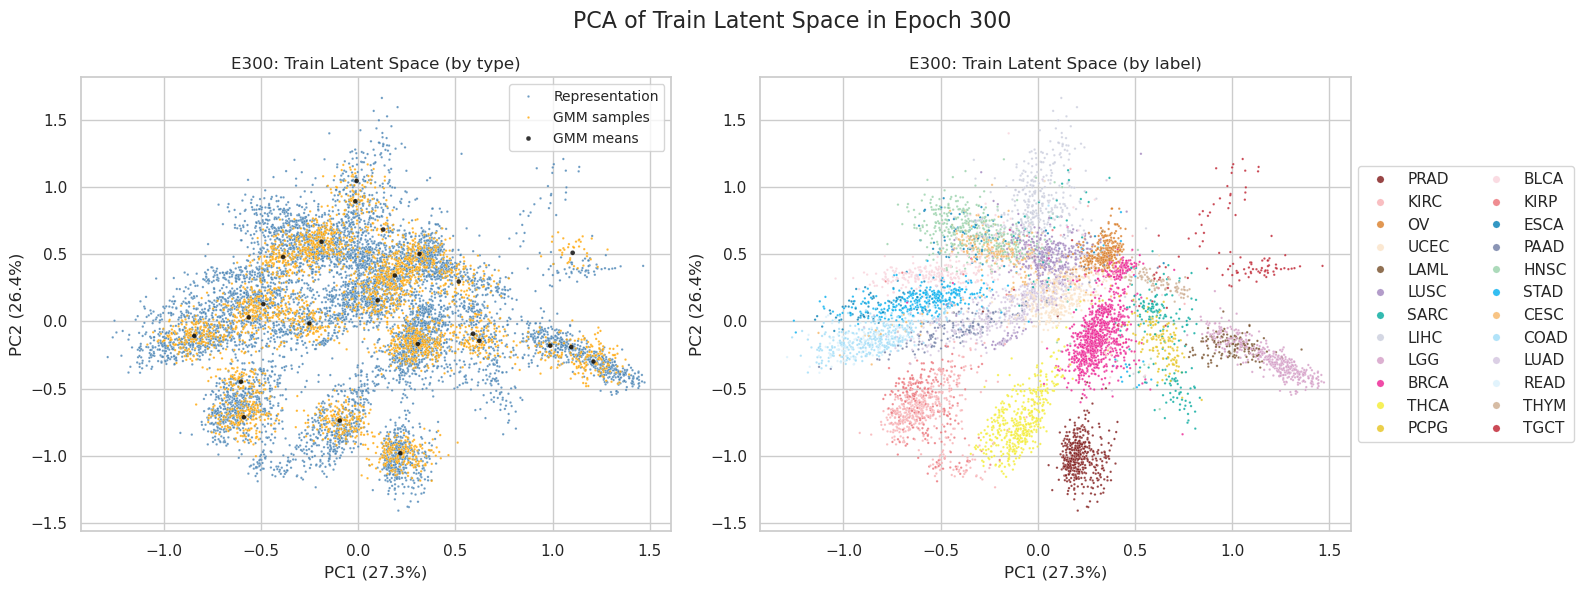

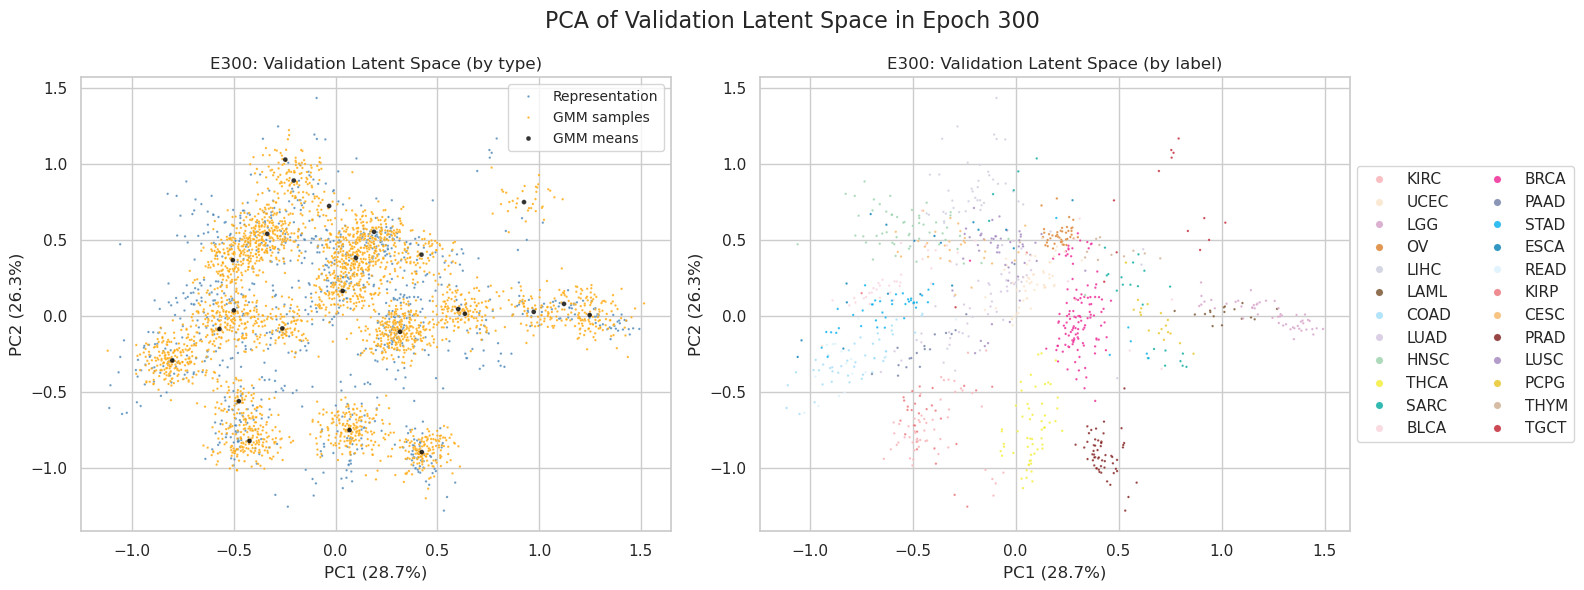

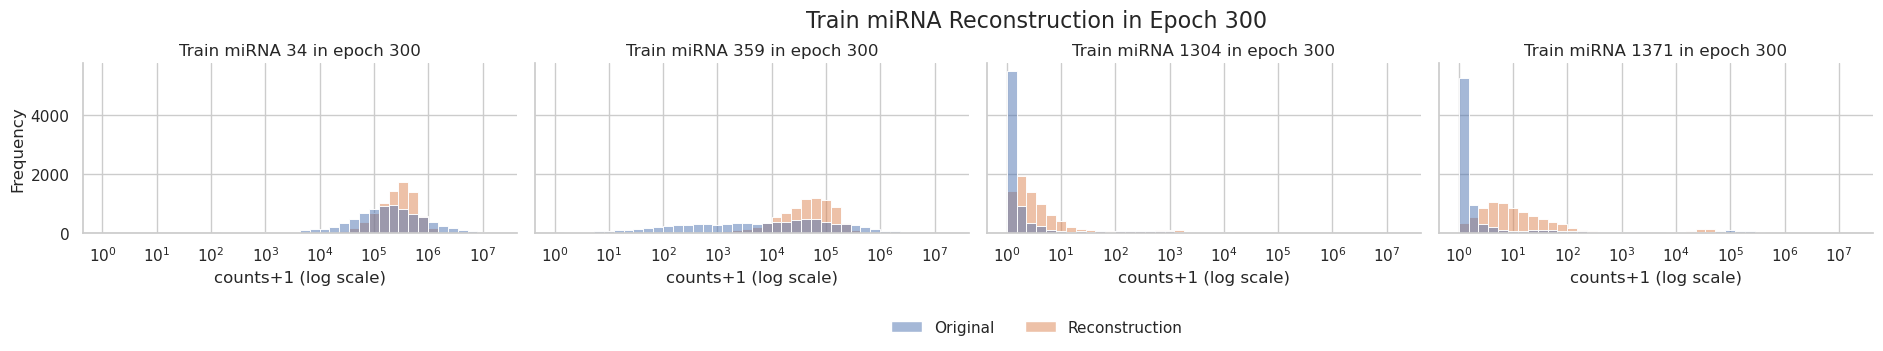

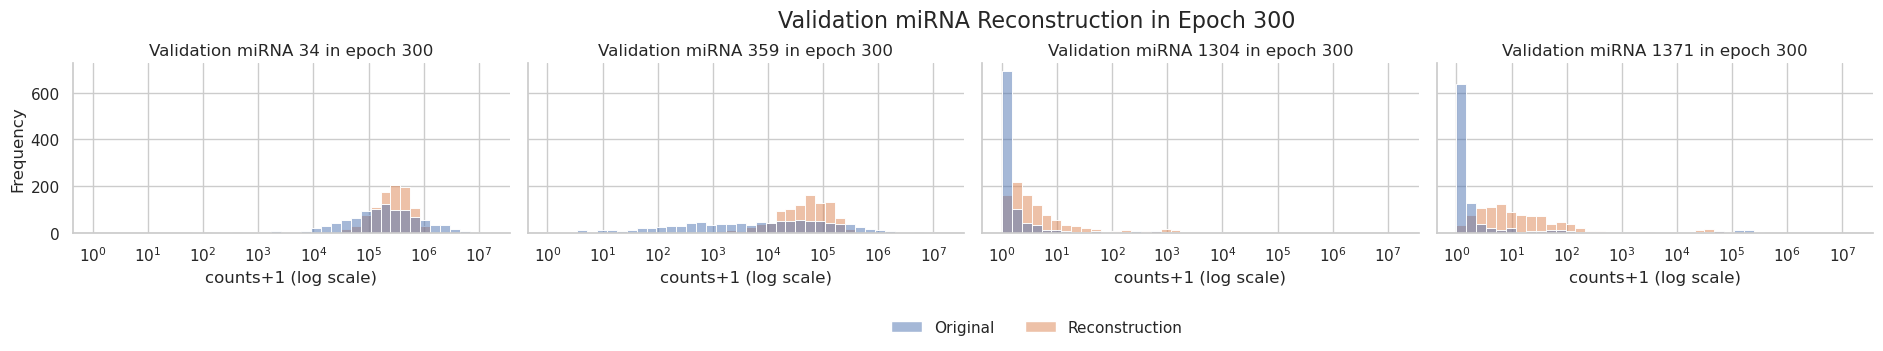

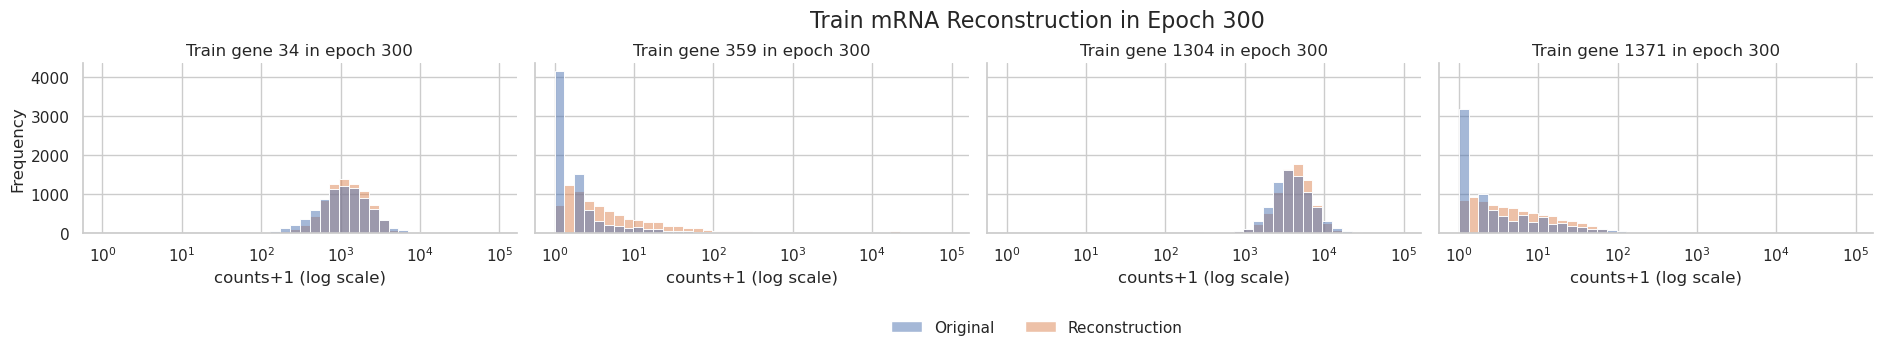

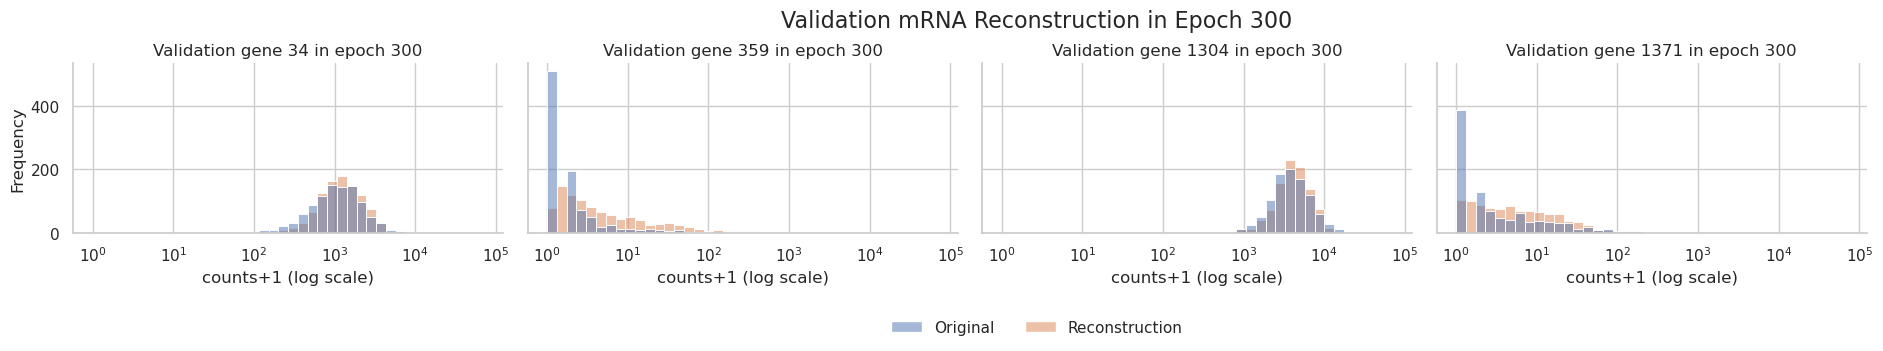

 20%|████████████████████████▋                                                                                                | 306/1500 [21:10<1:37:34,  4.90s/it]

305 train_loss: 10.480489551851116 train_recon_mirna: 1.856353557770732 train_recon_mrna: 6.398319630183457 train_gmm: 2.2258163638969273 train_mse: 508946912.0 train_mae: 3581.0361328125 train_r2: 0.36687231063842773 train_spearman: 0.3878242075443268 train_pearson: 0.8457057476043701 train_msle: 5.152121067047119
305 test_loss: 10.638592597727673 test_recon_mirna: 1.9844982623206118 test_recon_mrna: 6.431174925209069 test_gmm: 2.222919410197992 test_mse: 558166528.0 test_mae: 3973.94775390625 test_r2: 0.34697872400283813 test_spearman: 0.35065680742263794 test_pearson: 0.8598003387451172 test_msle: 5.696535587310791


 21%|█████████████████████████                                                                                                | 311/1500 [21:29<1:21:45,  4.13s/it]

310 train_loss: 10.474509105987146 train_recon_mirna: 1.8543799809282275 train_recon_mrna: 6.393684220091467 train_gmm: 2.226444904967451 train_mse: 505469920.0 train_mae: 3562.557373046875 train_r2: 0.3711976408958435 train_spearman: 0.38750335574150085 train_pearson: 0.8474899530410767 train_msle: 5.082276821136475
310 test_loss: 10.635102075378658 test_recon_mirna: 1.9855671637863732 test_recon_mrna: 6.425920950350472 test_gmm: 2.223613961241813 test_mse: 550999360.0 test_mae: 3946.62060546875 test_r2: 0.3553639054298401 test_spearman: 0.34977003931999207 test_pearson: 0.8597223162651062 test_msle: 5.714925765991211


 21%|█████████████████████████▍                                                                                               | 316/1500 [21:48<1:18:24,  3.97s/it]

315 train_loss: 10.468624239421562 train_recon_mirna: 1.8524872519643993 train_recon_mrna: 6.389162579617112 train_gmm: 2.2269744078400504 train_mse: 500797152.0 train_mae: 3538.047607421875 train_r2: 0.3770105242729187 train_spearman: 0.38854652643203735 train_pearson: 0.8476377725601196 train_msle: 4.691668510437012
315 test_loss: 10.636432146091828 test_recon_mirna: 1.9897413656341074 test_recon_mrna: 6.4222822050203705 test_gmm: 2.2244085754373493 test_mse: 543065728.0 test_mae: 3918.090087890625 test_r2: 0.364645779132843 test_spearman: 0.35017940402030945 test_pearson: 0.8610153794288635 test_msle: 5.304798603057861


 21%|█████████████████████████▉                                                                                               | 321/1500 [22:08<1:15:54,  3.86s/it]

320 train_loss: 10.463045907303236 train_recon_mirna: 1.8507057531076896 train_recon_mrna: 6.384796268034209 train_gmm: 2.2275438861613397 train_mse: 498356704.0 train_mae: 3528.12060546875 train_r2: 0.38004642724990845 train_spearman: 0.38938817381858826 train_pearson: 0.8494479060173035 train_msle: 4.93464994430542
320 test_loss: 10.628827656145095 test_recon_mirna: 1.9847570972272748 test_recon_mrna: 6.419249393398387 test_gmm: 2.2248211655194328 test_mse: 544880256.0 test_mae: 3919.70166015625 test_r2: 0.3625229597091675 test_spearman: 0.3513047695159912 test_pearson: 0.8581945896148682 test_msle: 5.560494422912598


 22%|██████████████████████████▎                                                                                              | 326/1500 [22:32<1:32:22,  4.72s/it]

325 train_loss: 10.457175140896762 train_recon_mirna: 1.8488380807460627 train_recon_mrna: 6.380268449520095 train_gmm: 2.2280686106306042 train_mse: 498350272.0 train_mae: 3519.983642578125 train_r2: 0.38005441427230835 train_spearman: 0.3942517042160034 train_pearson: 0.8483810424804688 train_msle: 4.612868309020996
325 test_loss: 10.624924545474702 test_recon_mirna: 1.9855423835892763 test_recon_mrna: 6.413782893852851 test_gmm: 2.225599268032575 test_mse: 545335616.0 test_mae: 3915.5869140625 test_r2: 0.36199021339416504 test_spearman: 0.3563554286956787 test_pearson: 0.8604451417922974 test_msle: 5.186337471008301


 22%|██████████████████████████▋                                                                                              | 331/1500 [22:53<1:21:20,  4.18s/it]

330 train_loss: 10.451830041426549 train_recon_mirna: 1.8471504273312849 train_recon_mrna: 6.376058099045862 train_gmm: 2.228621515049402 train_mse: 490717056.0 train_mae: 3488.2763671875 train_r2: 0.3895501494407654 train_spearman: 0.395123153924942 train_pearson: 0.8492400050163269 train_msle: 4.816511154174805
330 test_loss: 10.622892263164683 test_recon_mirna: 1.9866253197156358 test_recon_mrna: 6.410018687190429 test_gmm: 2.226248256258618 test_mse: 536154272.0 test_mae: 3887.135009765625 test_r2: 0.3727317452430725 test_spearman: 0.3571627140045166 test_pearson: 0.8628923296928406 test_msle: 5.409158229827881


 22%|███████████████████████████                                                                                              | 336/1500 [23:15<1:24:44,  4.37s/it]

335 train_loss: 10.446744498086325 train_recon_mirna: 1.8455844236403203 train_recon_mrna: 6.372042972662561 train_gmm: 2.2291171017834435 train_mse: 485171232.0 train_mae: 3461.294921875 train_r2: 0.39644908905029297 train_spearman: 0.39499470591545105 train_pearson: 0.85193932056427 train_msle: 4.4858245849609375
335 test_loss: 10.625826730846043 test_recon_mirna: 1.991345564063707 test_recon_mrna: 6.407741734259068 test_gmm: 2.2267394325232677 test_mse: 529374720.0 test_mae: 3857.510986328125 test_r2: 0.3806634545326233 test_spearman: 0.3555428385734558 test_pearson: 0.8632659316062927 test_msle: 5.055488109588623


 23%|███████████████████████████▌                                                                                             | 341/1500 [23:34<1:17:23,  4.01s/it]

340 train_loss: 10.441538059863007 train_recon_mirna: 1.843934513879233 train_recon_mrna: 6.3679999795856075 train_gmm: 2.2296035663981666 train_mse: 484056032.0 train_mae: 3454.295654296875 train_r2: 0.3978363871574402 train_spearman: 0.3971288800239563 train_pearson: 0.8520609140396118 train_msle: 4.596465587615967
340 test_loss: 10.620811094646946 test_recon_mirna: 1.9902087405886344 test_recon_mrna: 6.403249380406984 test_gmm: 2.2273529736513273 test_mse: 524188864.0 test_mae: 3841.381103515625 test_r2: 0.3867305517196655 test_spearman: 0.35926011204719543 test_pearson: 0.8620071411132812 test_msle: 5.216770648956299


 23%|███████████████████████████▉                                                                                             | 346/1500 [23:56<1:24:29,  4.39s/it]

345 train_loss: 10.436601597228526 train_recon_mirna: 1.8423410803176803 train_recon_mrna: 6.364185944137994 train_gmm: 2.2300745727728515 train_mse: 478546432.0 train_mae: 3429.9345703125 train_r2: 0.40469032526016235 train_spearman: 0.3968450427055359 train_pearson: 0.8520745635032654 train_msle: 4.758703708648682
345 test_loss: 10.615353014971133 test_recon_mirna: 1.988080326030754 test_recon_mrna: 6.399869153521558 test_gmm: 2.227403535418821 test_mse: 521167808.0 test_mae: 3831.72509765625 test_r2: 0.3902650475502014 test_spearman: 0.35927677154541016 test_pearson: 0.8607620000839233 test_msle: 5.309326648712158


 23%|████████████████████████████▎                                                                                            | 351/1500 [24:18<1:22:00,  4.28s/it]

350 train_loss: 10.431887853550755 train_recon_mirna: 1.8409256159259475 train_recon_mrna: 6.360464405672706 train_gmm: 2.230497831952101 train_mse: 477006208.0 train_mae: 3418.697021484375 train_r2: 0.40660637617111206 train_spearman: 0.39806050062179565 train_pearson: 0.8529708385467529 train_msle: 4.703043460845947
350 test_loss: 10.615853640404236 test_recon_mirna: 1.9906239845228508 test_recon_mrna: 6.396562160432618 test_gmm: 2.2286674954487675 test_mse: 522609664.0 test_mae: 3835.633056640625 test_r2: 0.3885781168937683 test_spearman: 0.3632659316062927 test_pearson: 0.8623835444450378 test_msle: 5.262578964233398


 24%|████████████████████████████▋                                                                                            | 356/1500 [24:37<1:13:23,  3.85s/it]

355 train_loss: 10.427342972880691 train_recon_mirna: 1.839463202354851 train_recon_mrna: 6.356890281918564 train_gmm: 2.230989488607276 train_mse: 476719520.0 train_mae: 3412.611083984375 train_r2: 0.4069629907608032 train_spearman: 0.40045180916786194 train_pearson: 0.8545568585395813 train_msle: 4.283792018890381
355 test_loss: 10.62179308217822 test_recon_mirna: 1.9975168390380582 test_recon_mrna: 6.395408335252796 test_gmm: 2.2288679078873663 test_mse: 521671808.0 test_mae: 3830.822021484375 test_r2: 0.3896753787994385 test_spearman: 0.3613946735858917 test_pearson: 0.8591901659965515 test_msle: 4.880042552947998


 24%|█████████████████████████████                                                                                            | 361/1500 [24:56<1:13:00,  3.85s/it]

360 train_loss: 10.42296276602238 train_recon_mirna: 1.8380387590810814 train_recon_mrna: 6.353445608734509 train_gmm: 2.2314783982067894 train_mse: 472115040.0 train_mae: 3392.30615234375 train_r2: 0.41269099712371826 train_spearman: 0.40135839581489563 train_pearson: 0.8532440066337585 train_msle: 4.611299514770508
360 test_loss: 10.61760117141699 test_recon_mirna: 1.9972332878007857 test_recon_mrna: 6.390979209721425 test_gmm: 2.2293886738947775 test_mse: 522064928.0 test_mae: 3833.898681640625 test_r2: 0.38921546936035156 test_spearman: 0.36123141646385193 test_pearson: 0.8623239398002625 test_msle: 5.292848587036133


 24%|█████████████████████████████▌                                                                                           | 366/1500 [25:15<1:12:53,  3.86s/it]

365 train_loss: 10.418733817376506 train_recon_mirna: 1.836671543824724 train_recon_mrna: 6.350166170270235 train_gmm: 2.2318961032815463 train_mse: 465734144.0 train_mae: 3365.063232421875 train_r2: 0.42062878608703613 train_spearman: 0.40128299593925476 train_pearson: 0.8541319966316223 train_msle: 4.430665493011475
365 test_loss: 10.616044061580101 test_recon_mirna: 1.9981339649388312 test_recon_mrna: 6.387989144006403 test_gmm: 2.2299209526348673 test_mse: 505688160.0 test_mae: 3772.753662109375 test_r2: 0.40837526321411133 test_spearman: 0.36823394894599915 test_pearson: 0.8634464740753174 test_msle: 4.932373523712158


 25%|█████████████████████████████▉                                                                                           | 371/1500 [25:33<1:08:55,  3.66s/it]

370 train_loss: 10.4144209036685 train_recon_mirna: 1.8353419803664868 train_recon_mrna: 6.346742897475227 train_gmm: 2.2323360258267857 train_mse: 468616320.0 train_mae: 3372.85400390625 train_r2: 0.4170433282852173 train_spearman: 0.4035494029521942 train_pearson: 0.8544758558273315 train_msle: 4.331366539001465
370 test_loss: 10.618762794092243 test_recon_mirna: 2.003064218263976 test_recon_mrna: 6.3851139579163405 test_gmm: 2.230584617911927 test_mse: 512592352.0 test_mae: 3795.68798828125 test_r2: 0.4002978205680847 test_spearman: 0.3682555854320526 test_pearson: 0.8589351773262024 test_msle: 4.9694623947143555


 25%|██████████████████████████████▎                                                                                          | 375/1500 [25:48<1:10:22,  3.75s/it]

375 train_loss: 10.41051266830762 train_recon_mirna: 1.8341228352916834 train_recon_mrna: 6.3436365915323565 train_gmm: 2.23275324148358 train_mse: 462867072.0 train_mae: 3347.028564453125 train_r2: 0.42419540882110596 train_spearman: 0.4026089608669281 train_pearson: 0.8546862006187439 train_msle: 4.371069431304932
375 test_loss: 10.617618928622488 test_recon_mirna: 2.0046575274574803 test_recon_mrna: 6.381860292441722 test_gmm: 2.2311011087232853 test_mse: 500328160.0 test_mae: 3748.3408203125 test_r2: 0.4146462082862854 test_spearman: 0.3695427477359772 test_pearson: 0.8577196002006531 test_msle: 4.906990051269531


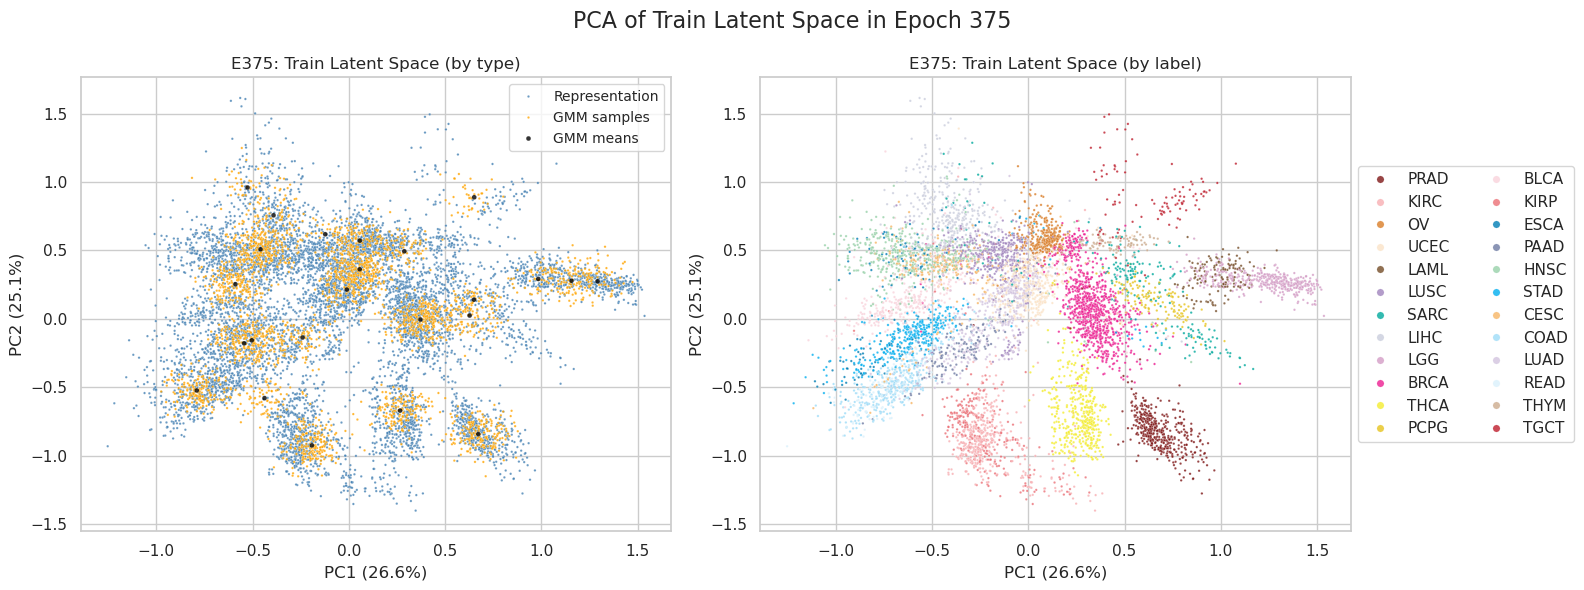

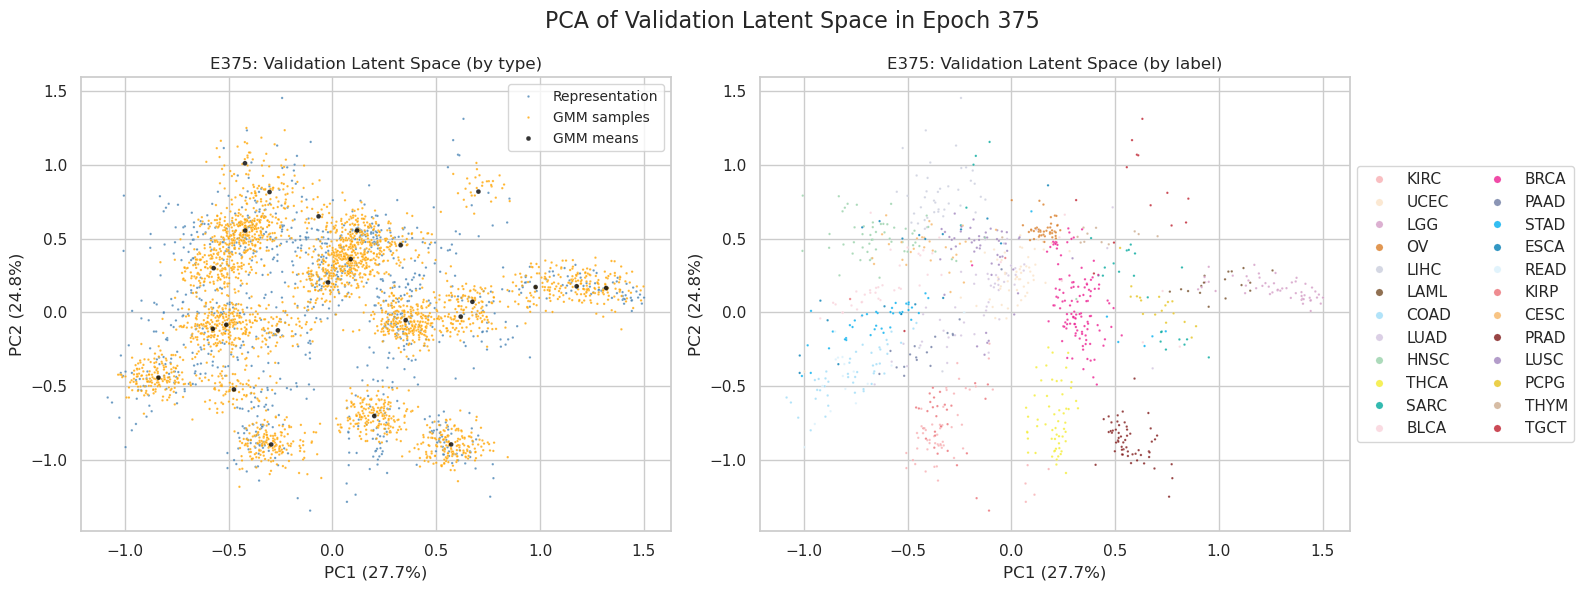

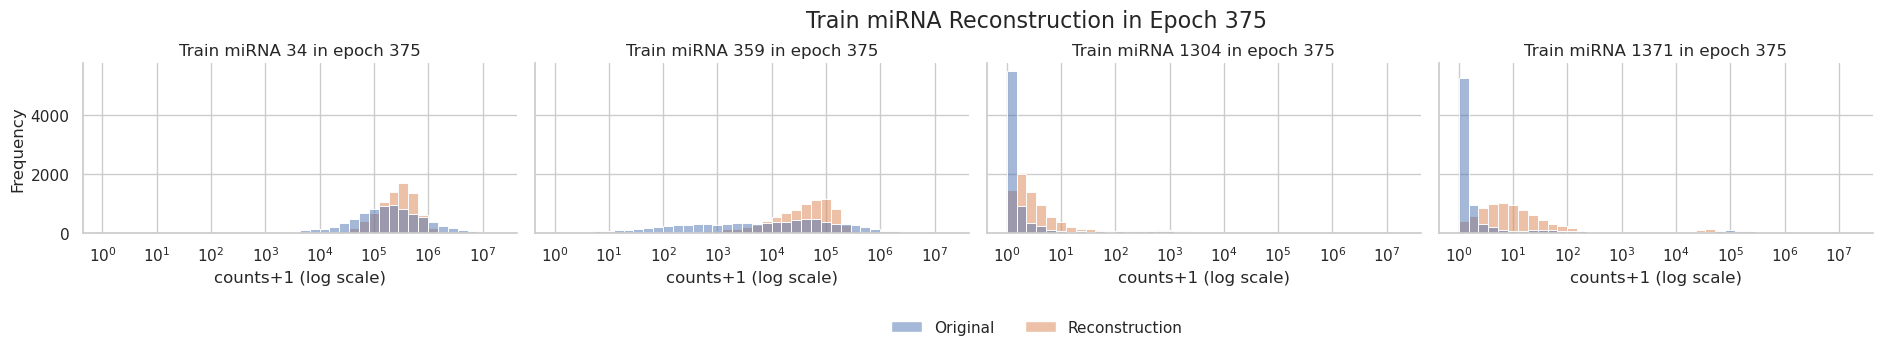

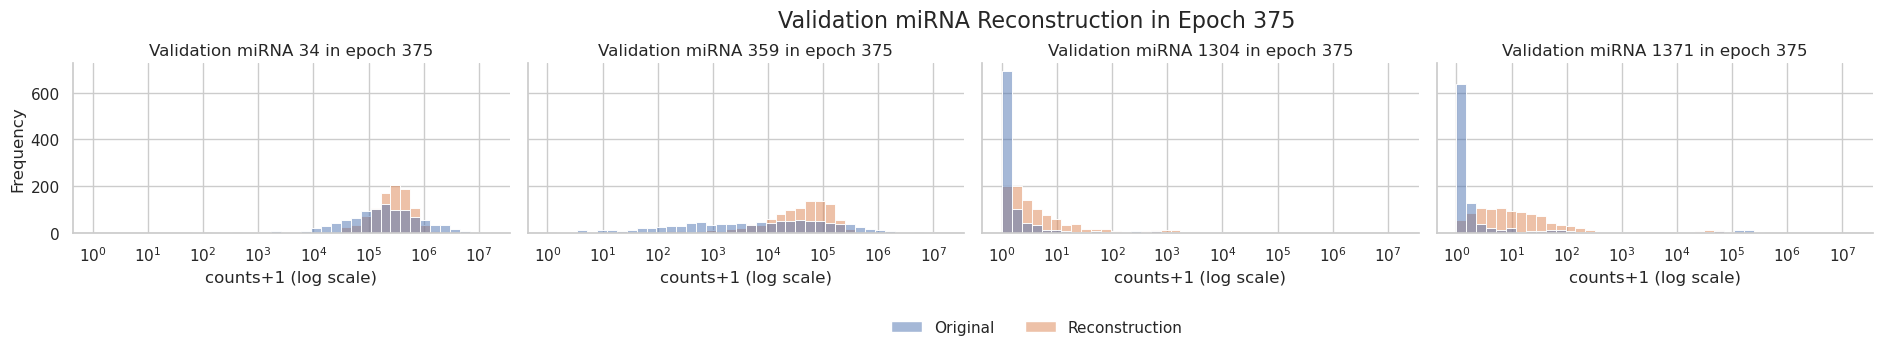

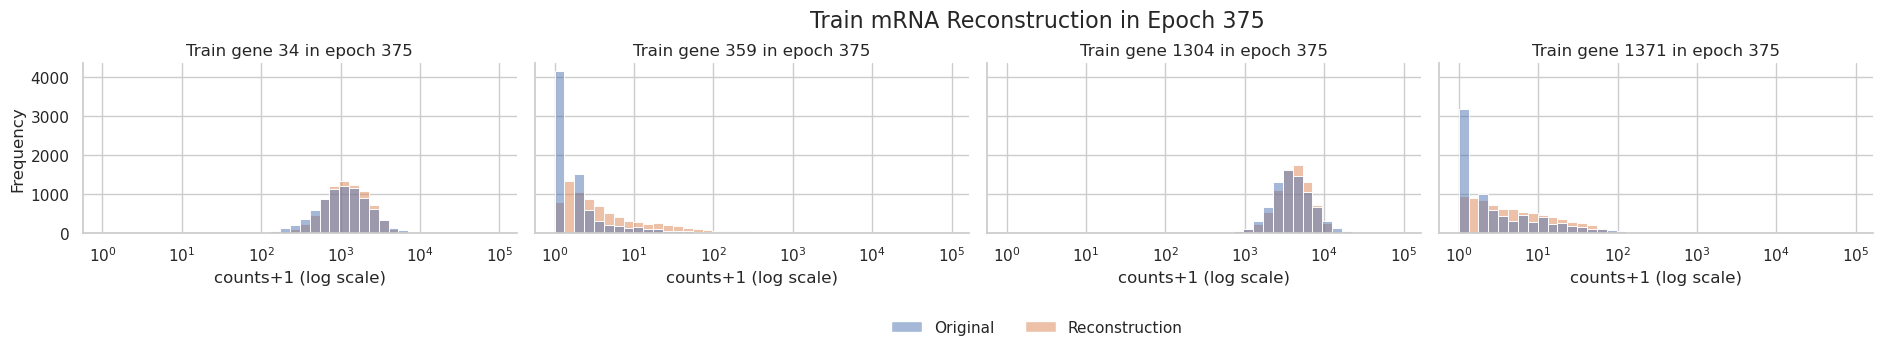

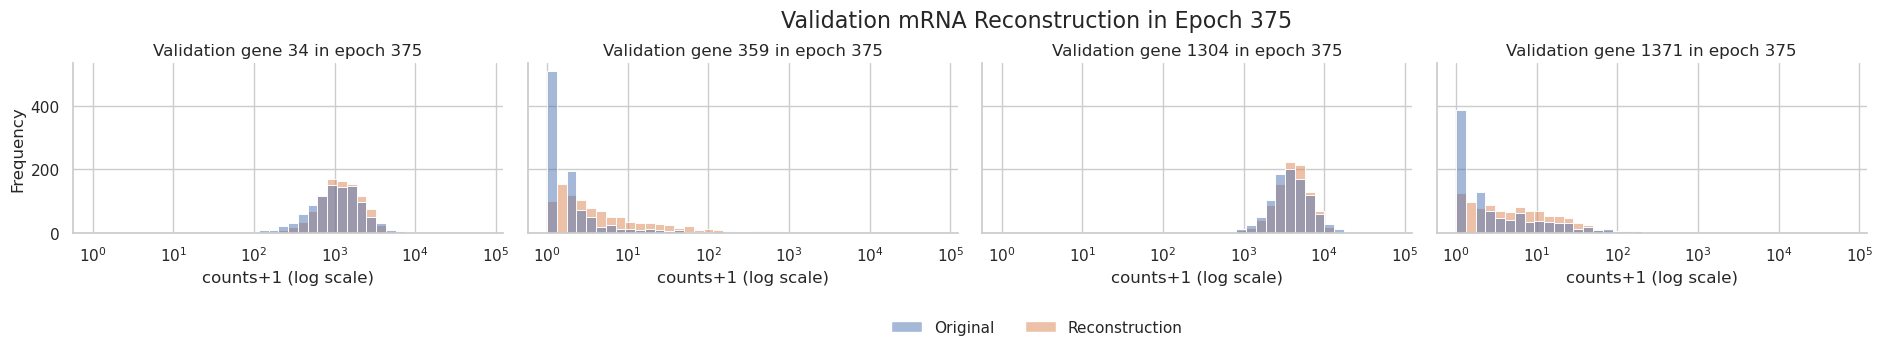

 25%|██████████████████████████████▋                                                                                          | 381/1500 [26:26<1:24:15,  4.52s/it]

380 train_loss: 10.406751999046032 train_recon_mirna: 1.8329147687974519 train_recon_mrna: 6.340696571820806 train_gmm: 2.2331406584277733 train_mse: 457775616.0 train_mae: 3319.33837890625 train_r2: 0.4305291175842285 train_spearman: 0.402100145816803 train_pearson: 0.8559147119522095 train_msle: 4.058894634246826
380 test_loss: 10.622379229427157 test_recon_mirna: 2.0117355628527984 test_recon_mrna: 6.37885430178097 test_gmm: 2.23178936479339 test_mse: 502325984.0 test_mae: 3754.13916015625 test_r2: 0.41230887174606323 test_spearman: 0.37209922075271606 test_pearson: 0.8632426261901855 test_msle: 4.536231517791748


 26%|███████████████████████████████▏                                                                                         | 386/1500 [26:45<1:10:26,  3.79s/it]

385 train_loss: 10.403112344321064 train_recon_mirna: 1.8317612375546086 train_recon_mrna: 6.337722877534113 train_gmm: 2.2336282292323433 train_mse: 460304416.0 train_mae: 3329.094970703125 train_r2: 0.4273833632469177 train_spearman: 0.40372422337532043 train_pearson: 0.8541849255561829 train_msle: 4.148562908172607
385 test_loss: 10.62904768053383 test_recon_mirna: 2.0200843178139474 test_recon_mrna: 6.376580334776933 test_gmm: 2.2323830279429506 test_mse: 503302624.0 test_mae: 3752.528564453125 test_r2: 0.411166250705719 test_spearman: 0.3702342212200165 test_pearson: 0.8598639369010925 test_msle: 4.781454563140869


 26%|███████████████████████████████▌                                                                                         | 391/1500 [27:03<1:09:44,  3.77s/it]

390 train_loss: 10.39954846263137 train_recon_mirna: 1.8306132236365886 train_recon_mrna: 6.33485677154956 train_gmm: 2.2340784674452223 train_mse: 453655456.0 train_mae: 3295.33154296875 train_r2: 0.43565458059310913 train_spearman: 0.405837744474411 train_pearson: 0.855293333530426 train_msle: 3.982614040374756
390 test_loss: 10.651059866667342 test_recon_mirna: 2.038913259985653 test_recon_mrna: 6.3793498609474595 test_gmm: 2.2327967457342295 test_mse: 494580384.0 test_mae: 3717.096923828125 test_r2: 0.4213706851005554 test_spearman: 0.374338835477829 test_pearson: 0.8605859875679016 test_msle: 4.5537800788879395


 26%|███████████████████████████████▉                                                                                         | 396/1500 [27:23<1:10:47,  3.85s/it]

395 train_loss: 10.396096973121594 train_recon_mirna: 1.8295713837755776 train_recon_mrna: 6.332049232464712 train_gmm: 2.234476356881305 train_mse: 450219456.0 train_mae: 3279.823974609375 train_r2: 0.43992894887924194 train_spearman: 0.40744832158088684 train_pearson: 0.8553800582885742 train_msle: 4.052623748779297
395 test_loss: 10.64464888021012 test_recon_mirna: 2.038998569646149 test_recon_mrna: 6.372064303045012 test_gmm: 2.233586007518959 test_mse: 493675392.0 test_mae: 3716.56689453125 test_r2: 0.42242950201034546 test_spearman: 0.3782300651073456 test_pearson: 0.8600602149963379 test_msle: 4.575428485870361


 27%|████████████████████████████████▎                                                                                        | 401/1500 [27:43<1:10:39,  3.86s/it]

400 train_loss: 10.392766799430097 train_recon_mirna: 1.8285119585649265 train_recon_mrna: 6.329442463293337 train_gmm: 2.2348123775718336 train_mse: 448242944.0 train_mae: 3272.72802734375 train_r2: 0.44238775968551636 train_spearman: 0.40773507952690125 train_pearson: 0.8548675179481506 train_msle: 4.135580062866211
400 test_loss: 10.64514414951301 test_recon_mirna: 2.0416274739322544 test_recon_mrna: 6.369533074828858 test_gmm: 2.233983600751896 test_mse: 492613952.0 test_mae: 3712.982421875 test_r2: 0.4236713647842407 test_spearman: 0.37850135564804077 test_pearson: 0.8602722883224487 test_msle: 4.619001865386963


 27%|████████████████████████████████▊                                                                                        | 406/1500 [28:02<1:09:45,  3.83s/it]

405 train_loss: 10.389566525340246 train_recon_mirna: 1.8273689907127149 train_recon_mrna: 6.326898820847408 train_gmm: 2.2352987137801237 train_mse: 448565984.0 train_mae: 3269.720703125 train_r2: 0.4419859051704407 train_spearman: 0.4104756712913513 train_pearson: 0.8540943264961243 train_msle: 3.9105470180511475
405 test_loss: 10.667786885908816 test_recon_mirna: 2.0655366119748133 test_recon_mrna: 6.368057188575507 test_gmm: 2.234193085358497 test_mse: 494717888.0 test_mae: 3714.108642578125 test_r2: 0.4212098717689514 test_spearman: 0.3815372884273529 test_pearson: 0.8591070175170898 test_msle: 4.437041759490967


 27%|█████████████████████████████████▏                                                                                       | 411/1500 [28:22<1:15:48,  4.18s/it]

410 train_loss: 10.386512296673727 train_recon_mirna: 1.8265139481406132 train_recon_mrna: 6.324361618500188 train_gmm: 2.235636730032926 train_mse: 446678560.0 train_mae: 3259.883544921875 train_r2: 0.44433385133743286 train_spearman: 0.41251951456069946 train_pearson: 0.8544086217880249 train_msle: 3.952376365661621
410 test_loss: 10.69154335527113 test_recon_mirna: 2.0907575038013335 test_recon_mrna: 6.365790241119917 test_gmm: 2.234995610349879 test_mse: 493155008.0 test_mae: 3711.46533203125 test_r2: 0.4230383038520813 test_spearman: 0.38625383377075195 test_pearson: 0.8598355054855347 test_msle: 4.461905479431152


 28%|█████████████████████████████████▌                                                                                       | 416/1500 [28:42<1:13:15,  4.06s/it]

415 train_loss: 10.383717235698658 train_recon_mirna: 1.8255934385057786 train_recon_mrna: 6.321990096372965 train_gmm: 2.236133700819915 train_mse: 443601568.0 train_mae: 3245.9990234375 train_r2: 0.44816160202026367 train_spearman: 0.41168728470802307 train_pearson: 0.8547122478485107 train_msle: 3.8466994762420654
415 test_loss: 10.722945692636195 test_recon_mirna: 2.123691631139869 test_recon_mrna: 6.363980664391879 test_gmm: 2.235273397104447 test_mse: 485631424.0 test_mae: 3681.578125 test_r2: 0.4318404793739319 test_spearman: 0.38527312874794006 test_pearson: 0.8589379787445068 test_msle: 4.442785263061523


 28%|█████████████████████████████████▉                                                                                       | 421/1500 [29:01<1:09:22,  3.86s/it]

420 train_loss: 10.380753706765688 train_recon_mirna: 1.824637122171679 train_recon_mrna: 6.319576205864916 train_gmm: 2.2365403787290914 train_mse: 441894848.0 train_mae: 3237.237548828125 train_r2: 0.4502847194671631 train_spearman: 0.4096842110157013 train_pearson: 0.8543830513954163 train_msle: 3.83298397064209
420 test_loss: 10.728092243303317 test_recon_mirna: 2.1300447020705002 test_recon_mrna: 6.362457527148234 test_gmm: 2.235590014084583 test_mse: 483117344.0 test_mae: 3662.876953125 test_r2: 0.4347817897796631 test_spearman: 0.3818437457084656 test_pearson: 0.8590896129608154 test_msle: 4.358855247497559


 28%|██████████████████████████████████▎                                                                                      | 425/1500 [29:21<1:14:14,  4.14s/it]

425 train_loss: 10.377928198636596 train_recon_mirna: 1.8237713095339116 train_recon_mrna: 6.317199078951889 train_gmm: 2.236957810150794 train_mse: 436704992.0 train_mae: 3216.288330078125 train_r2: 0.4567409157752991 train_spearman: 0.4115925431251526 train_pearson: 0.8536075949668884 train_msle: 3.8869619369506836
425 test_loss: 10.7357828068854 test_recon_mirna: 2.139136527645503 test_recon_mrna: 6.360379269345679 test_gmm: 2.2362670098942177 test_mse: 479897408.0 test_mae: 3644.89453125 test_r2: 0.4385489225387573 test_spearman: 0.388514906167984 test_pearson: 0.8575925230979919 test_msle: 4.3977274894714355
Early stopped training at epoch 425


In [16]:
learning_rates={'dec':1e-4, 'rep':1e-2, 'gmm':1e-2}
weight_decay={'dec':1e-4, 'rep':1e-4, 'gmm':1e-4}
betas=(0.7, 0.9)
nepochs = 1500
pr = 5 # how often to print epoch
plot = 75 # how often to print plot

sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728']
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]

print(sample_index)
subset = sample_index[0]

loss_tab = train_midgd(dgd, train_loader, validation_loader, device,
                       learning_rates=learning_rates, weight_decay=weight_decay, betas=betas, 
                       nepochs=nepochs, fold=None, pr=pr, plot=plot, 
                       reduction_type=reduction_type, scaling_type=scaling_type,
                       sample_index=sample_index, subset=subset, wandb_log=False, early_stopping=50, is_plot=True)

# Plotting Loss

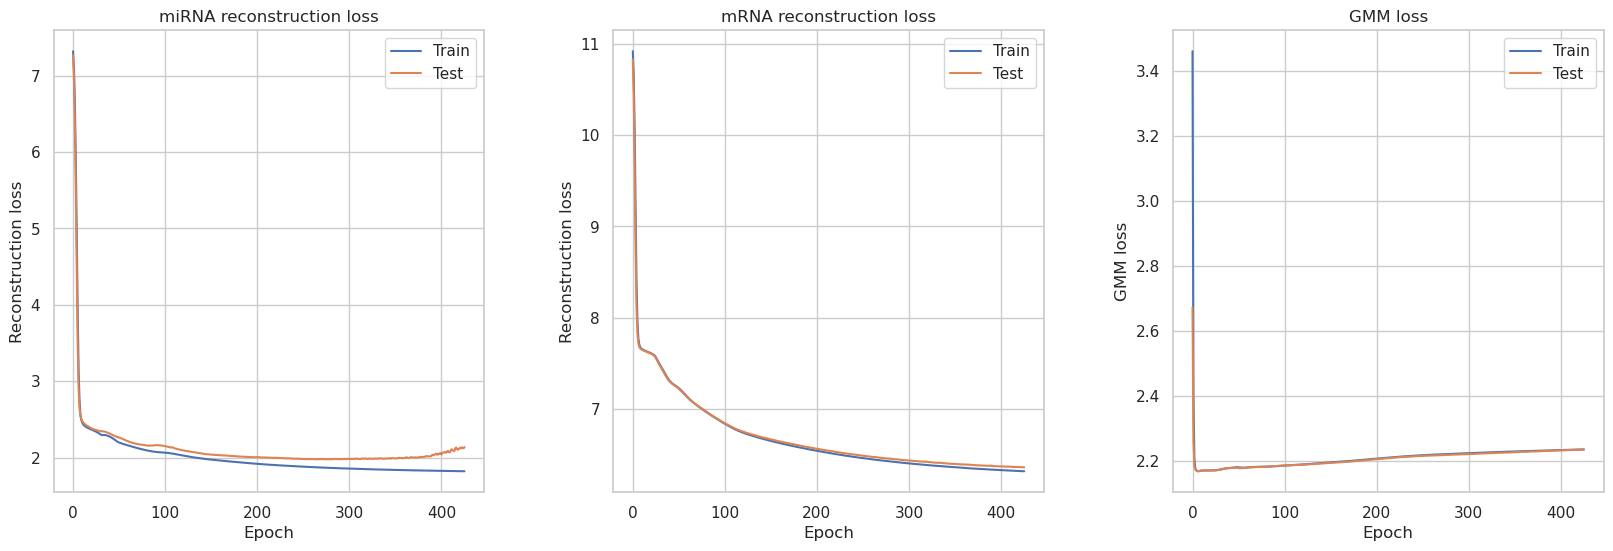

In [17]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon_mirna", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon_mirna", data=loss_tab, label="Test")
plt.title("miRNA reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_recon_mrna", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon_mrna", data=loss_tab, label="Test")
plt.title("mRNA reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Display the plots
plt.show()

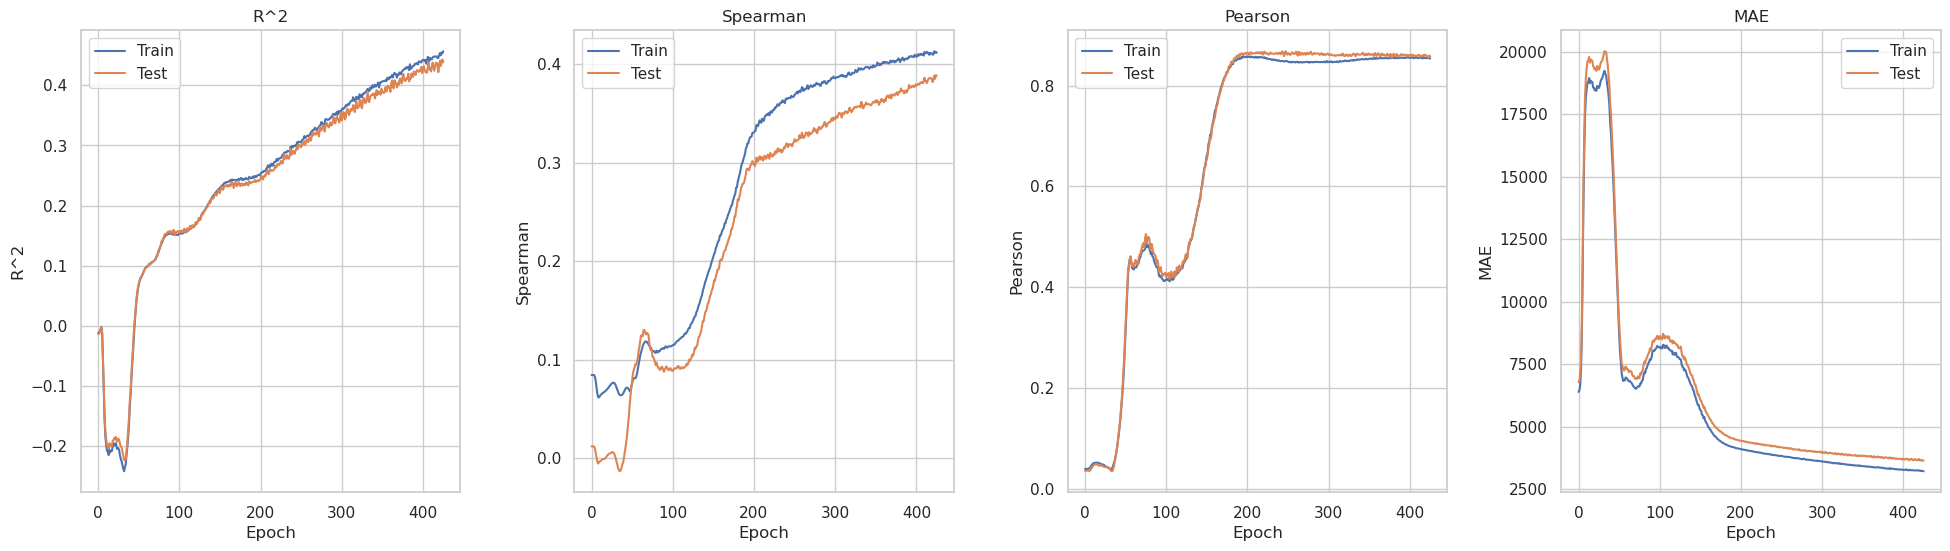

In [18]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for R-squared
plt.subplot(1, 4, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for Corr
plt.subplot(1, 4, 2)
sns.lineplot(x="epoch", y="train_spearman", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_spearman", data=loss_tab, label="Test")
plt.title("Spearman")
plt.xlabel("Epoch")
plt.ylabel("Spearman")

# Third subplot for MSE
plt.subplot(1, 4, 3)
sns.lineplot(x="epoch", y="train_pearson", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_pearson", data=loss_tab, label="Test")
plt.title("Pearson")
plt.xlabel("Epoch")
plt.ylabel("Pearson")

# Fourth subplot for MAE
plt.subplot(1, 4, 4)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Display the plots
plt.show()

# Save Model

In [19]:
torch.save(dgd, "models/midgd-ms-filtered-0918.pth")

# Overall Model Performance

In [20]:
from base.engine.predict import learn_new_representation #, learn_new_representation_mrna

In [21]:
new_rep = learn_new_representation(dgd, test_loader, learning_rates=1e-2, weight_decay=0., test_epochs=50)
dgd.test_rep = new_rep

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/it]


In [22]:
mirna_annot = pd.read_table("data/TCGA_mirna_anno_iso_match.tsv", sep='\t', index_col=[0])

# Change column name
mirna_column = pd.Series(train_mirna.columns[:-4])

# Convert mirna_annot DataFrame to a dictionary for mapping
mapping_dict = dict(zip(mirna_annot['mature_iso_id'], mirna_annot['mature_iso_name_miRBase']))

# Replace the values in mirna_column using the mapping dictionary
mirna_column = mirna_column.map(mapping_dict).fillna(mirna_column)
mirna_column = np.array(mirna_column)

print(mirna_column)

def _add_columns(X, y, data_loader):
    X = X.assign(tissue=data_loader.dataset.tissue_type)
    X = X.assign(sample=data_loader.dataset.sample_type)
    X = X.assign(color=data_loader.dataset.color)
    X = X.assign(cancer_type=data_loader.dataset.label)
    
    y = y.assign(tissue=data_loader.dataset.tissue_type)
    y = y.assign(sample=data_loader.dataset.sample_type)
    y = y.assign(color=data_loader.dataset.color)
    y = y.assign(cancer_type=data_loader.dataset.label)
    return X, y

def _get_data_prediction(dgd, data_loader, mirna_column_name, dataset="train"):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        if dataset == "train":
            X, _ = dgd.forward(dgd.train_rep()) 
        elif dataset == "val":
            X, _ = dgd.forward(dgd.val_rep()) 
        elif dataset == "test":
            X, _ = dgd.forward(dgd.test_rep()) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y

def _get_data_pred_from_rep(dgd, test_rep, data_loader, mirna_column_name):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        X, _ = dgd.forward(test_rep.z) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y
    
def generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column_name, subset=False, dataset="test"):
    if subset:
        if dataset == "train":
            X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
            train = pd.DataFrame(
                data={
                    'X': X_train[subset], 
                    'y': y_train[subset],
                    'cancer_type': train_loader.dataset.label,
                    'tissue': train_loader.dataset.tissue_type,
                    'color': train_loader.dataset.color
                }
            )
            return train
        elif dataset == "val":
            X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
            val = pd.DataFrame(
                data={
                    'X': X_val[subset], 
                    'y': y_val[subset],
                    'cancer_type': validation_loader.dataset.label,
                    'tissue': validation_loader.dataset.tissue_type,
                    'color': validation_loader.dataset.color
                }
            )
            return val
        elif dataset == "test":
            X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
            test = pd.DataFrame(
                data={
                    'X': X_test[subset], 
                    'y': y_test[subset],
                    'cancer_type': test_loader.dataset.label,
                    'tissue': test_loader.dataset.tissue_type,
                    'color': test_loader.dataset.color
                }
            )
            return test
    else:
        X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
        X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
        X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
        
    return X_train, y_train, X_val, y_val, X_test, y_test

def get_mirna_data(dgd, data_loader, subset, mirna_column_name=mirna_column, dataset="test"):
    return generate_analysis_data(dgd, *data_loader, mirna_column_name, subset=subset, dataset=dataset)

X_train, y_train, X_val, y_val, X_test, y_test = generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column)

['hsa-let-7a-5p' 'hsa-let-7a-2-3p' 'hsa-let-7b-5p' ... 'hsa-miR-3168'
 'hsa-miR-3119' 'hsa-miR-6823-3p']


In [23]:
from scipy import stats

def calculate_corr(X, y, axis=0):
    spearman_corr = []
    pearson_corr = []
    spearman_pval = []
    pearson_pval = []
    r2 = []
    r2_pval = []
    X = X.iloc[:,:-4]
    y = y.iloc[:,:-4]
    
    if axis == 0:
        for i in range(y.shape[1]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[:, i], y.iloc[:, i])
            pearson, pearson_p = stats.pearsonr(X.iloc[:, i], y.iloc[:, i])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[:, i], y.iloc[:, i])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.columns
            },
            index=np.arange(0, len(X.columns))
        )
    elif axis == 1:
        for i in range(y.shape[0]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[i, :], y.iloc[i, :])
            pearson, pearson_p = stats.pearsonr(X.iloc[i, :], y.iloc[i, :])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[i, :], y.iloc[i, :])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.index[:-4]
            },
            index=np.arange(0, len(X.index))
        )
    else:
        raise ValueError("Axis must be 0 (columns) or 1 (rows).")
    
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_pearson(X, y, sparsity):
    pearson_corr = []
    pearson_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        pearson, pearson_p = stats.pearsonr(X.iloc[:,i], y.iloc[:,i])
        pearson_corr.append(pearson)
        pearson_pval.append(pearson_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'pearson': pearson_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_spearman(X, y, sparsity):
    spearman_corr = []
    spearman_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        spearman, spearman_p = stats.spearmanr(X.iloc[:,i], y.iloc[:,i])
        spearman_corr.append(spearman)
        spearman_pval.append(spearman_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'spearman': spearman_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='spearman', ascending=False, ignore_index=True)

def plot_average_correlation(savedir='plots', filename='None'):
    sns.set_theme(style="whitegrid")
    sns.set_style("white")
    fig = plt.figure(figsize=(8,3))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=corr_data, x='spearman', bins=50)
    # plt.title("Spearman's Correlation")
    plt.xlabel("Spearman's Correlation")
    mean_spearman = corr_data['spearman'].mean()
    plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')
    
    plt.subplot(1,2,2)
    sns.histplot(data=corr_data, x='pearson', bins=50)
    # plt.title("Pearson's Correlation")
    plt.xlabel("Pearson's Correlation")
    plt.ylabel("")
    mean_pearson = corr_data['pearson'].mean()
    plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')
    
    # Add the main title to the figure
    # fig.suptitle("samples correlation histogram", fontsize=16)
    
    # Display the plots
    sns.despine()
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()

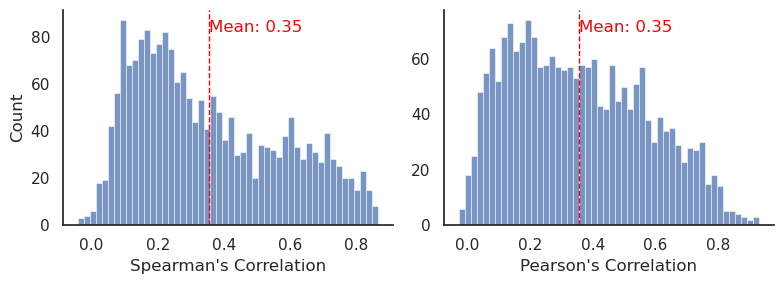

In [24]:
corr_data = calculate_corr(X_test, y_test, axis=0)
plot_average_correlation(corr_data, filename=None)